In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 91 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 30.6 MB 25 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [3]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [6]:
print(len(files_all))

297


In [7]:
from multiprocessing import Pool

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:34<00:00,  1.58s/it]


In [10]:
Dataset = 'Small Village Dataset'

In [11]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 10.279684782028198 [s] ... size 708.480038 MB


In [ ]:
'''f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [12]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [13]:
from timeit import default_timer as timer

In [14]:
time_all = []

In [15]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [16]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
''''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [17]:
start = timer()

Threshl=80;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.36it/s]


In [18]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 282286.30it/s]


In [ ]:
'''all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [19]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


In [20]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 370630.69it/s]


In [ ]:
'''all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_left

In [ ]:
''''import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_right

FAST + SIFT

In [21]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:38<00:00,  1.57it/s]


In [22]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 397564.36it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [23]:

print(len(left_files_path))

61


In [24]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [25]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=6)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


In [26]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 122104.92it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [27]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 4, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:52<00:00,  1.88s/it]


In [28]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 245161.46it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [29]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [30]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [31]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [32]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [33]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:07,  8.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 62




  7%|▋         | 4/61 [00:00<00:06,  9.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 72



Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 128




  8%|▊         | 5/61 [00:00<00:06,  9.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 72



Number of matches 1001
Number of matches After Lowe's Ratio 148
Number of Robust matches 111




 15%|█▍        | 9/61 [00:00<00:05,  9.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 116
Number of Robust matches 85



Number of matches 1001
Number of matches After Lowe's Ratio 181
Number of Robust matches 103



Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 147




 18%|█▊        | 11/61 [00:01<00:05,  9.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 49




 21%|██▏       | 13/61 [00:01<00:05,  9.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 167
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 28




 25%|██▍       | 15/61 [00:01<00:05,  9.10it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 34
Number of Robust matches 24


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 29



Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 27




 28%|██▊       | 17/61 [00:01<00:04,  9.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 64



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 69




 31%|███       | 19/61 [00:02<00:04,  9.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 104
Number of Robust matches 48




 33%|███▎      | 20/61 [00:02<00:04,  9.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 85



Number of matches 1000
Number of matches After Lowe's Ratio 157


 38%|███▊      | 23/61 [00:02<00:04,  9.43it/s]

Number of Robust matches 123



Number of matches 1001
Number of matches After Lowe's Ratio 153
Number of Robust matches 116




 41%|████      | 25/61 [00:02<00:03,  9.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 71




 44%|████▍     | 27/61 [00:03<00:04,  8.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 23


Number of matches After Lowe's Ratio New 152
Number of Robust matches New 33



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 59




 48%|████▊     | 29/61 [00:03<00:04,  7.51it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 93
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 8


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 13




 51%|█████     | 31/61 [00:03<00:03,  7.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 16


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 21



Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 37




 54%|█████▍    | 33/61 [00:03<00:03,  8.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 62




 57%|█████▋    | 35/61 [00:04<00:03,  8.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 77




 61%|██████    | 37/61 [00:04<00:02,  8.78it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 81



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 85




 64%|██████▍   | 39/61 [00:04<00:02,  8.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 149
Number of Robust matches 105



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 129




 66%|██████▌   | 40/61 [00:04<00:02,  8.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 72



Number of matches 1000
Number of matches After Lowe's Ratio 161


 70%|███████   | 43/61 [00:04<00:01,  9.05it/s]

Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 53




 72%|███████▏  | 44/61 [00:05<00:02,  7.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 20
Number of Robust matches 6


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 9


 75%|███████▌  | 46/61 [00:05<00:02,  6.48it/s]

Number of Robust matches 4


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 7


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 9




 79%|███████▊  | 48/61 [00:05<00:01,  6.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 9


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 32




 82%|████████▏ | 50/61 [00:05<00:01,  7.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 65



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 68




 85%|████████▌ | 52/61 [00:06<00:01,  8.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 93




 89%|████████▊ | 54/61 [00:06<00:00,  8.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 129



Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 150




 92%|█████████▏| 56/61 [00:06<00:00,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 135
Number of Robust matches 126



Number of matches 1001
Number of matches After Lowe's Ratio 71
Number of Robust matches 58




 95%|█████████▌| 58/61 [00:06<00:00,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 165
Number of Robust matches 69




 98%|█████████▊| 60/61 [00:07<00:00,  8.44it/s]



Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 26
Number of Robust matches 19


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 31




  2%|▏         | 1/60 [00:00<00:06,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 42



Number of matches 1001
Number of matches After Lowe's Ratio 57
Number of Robust matches 33




  7%|▋         | 4/60 [00:00<00:06,  8.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 19


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 45




 10%|█         | 6/60 [00:00<00:06,  8.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 86



Number of matches 1001
Number of matches After Lowe's Ratio 134
Number of Robust matches 72




 13%|█▎        | 8/60 [00:00<00:05,  8.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 73



Number of matches 1000
Number of matches After Lowe's Ratio 182
Number of Robust matches 112




 17%|█▋        | 10/60 [00:01<00:05,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 151



Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 101




 20%|██        | 12/60 [00:01<00:05,  9.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 182
Number of Robust matches 124



Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 50




 23%|██▎       | 14/60 [00:01<00:05,  9.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 109



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 105




 27%|██▋       | 16/60 [00:01<00:04,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 105
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 57




 30%|███       | 18/60 [00:02<00:04,  9.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 39



Number of matches 1002
Number of matches After Lowe's Ratio 68
Number of Robust matches 42




 33%|███▎      | 20/60 [00:02<00:04,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 37
Number of Robust matches 19


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 52




 37%|███▋      | 22/60 [00:02<00:04,  9.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 96



Number of matches 1000
Number of matches After Lowe's Ratio 146
Number of Robust matches 83




 42%|████▏     | 25/60 [00:02<00:03,  9.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 86



Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 88



Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 121




 45%|████▌     | 27/60 [00:03<00:03,  9.53it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 129
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 149
Number of Robust matches 112




 48%|████▊     | 29/60 [00:03<00:03,  9.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 79




 52%|█████▏    | 31/60 [00:03<00:03,  9.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 169
Number of Robust matches 86



Number of matches 1002
Number of matches After Lowe's Ratio 145
Number of Robust matches 75




 55%|█████▌    | 33/60 [00:03<00:02,  9.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 145
Number of Robust matches 72



Number of matches 1001
Number of matches After Lowe's Ratio 137
Number of Robust matches 80




 58%|█████▊    | 35/60 [00:03<00:02,  9.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 35




 62%|██████▏   | 37/60 [00:04<00:02,  9.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 61



Number of matches 1001
Number of matches After Lowe's Ratio 132
Number of Robust matches 79




 65%|██████▌   | 39/60 [00:04<00:02,  9.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 191
Number of Robust matches 110




 68%|██████▊   | 41/60 [00:04<00:02,  9.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 142



Number of matches 1001
Number of matches After Lowe's Ratio 110
Number of Robust matches 99




 72%|███████▏  | 43/60 [00:04<00:01,  8.90it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 90
Number of Robust matches 84



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 74




 75%|███████▌  | 45/60 [00:05<00:01,  8.97it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 77
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 105




 78%|███████▊  | 47/60 [00:05<00:01,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 87



Number of matches 1000
Number of matches After Lowe's Ratio 144
Number of Robust matches 60




 82%|████████▏ | 49/60 [00:05<00:01,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 104
Number of Robust matches 39



Number of matches 1001
Number of matches After Lowe's Ratio 78
Number of Robust matches 36




 85%|████████▌ | 51/60 [00:05<00:01,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 55



Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 60




 88%|████████▊ | 53/60 [00:05<00:00,  8.46it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 38
Number of Robust matches 22


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 30



Number of matches 1001
Number of matches After Lowe's Ratio 131
Number of Robust matches 42




 92%|█████████▏| 55/60 [00:06<00:00,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 86



Number of matches 1001
Number of matches After Lowe's Ratio 204
Number of Robust matches 117




 95%|█████████▌| 57/60 [00:06<00:00,  9.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 118



Number of matches 1001
Number of matches After Lowe's Ratio 207
Number of Robust matches 158




 98%|█████████▊| 59/60 [00:06<00:00,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 231
Number of Robust matches 213



Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 223




In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01051950454711914 [s] ... size 0.006368 MB


In [35]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0037107467651367188 [s] ... size 0.006296 MB


In [36]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [37]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:18,  1.31s/it]


Number of matches 8679
Number of matches After Lowe's Ratio 2670
Number of Robust matches 1269




  3%|▎         | 2/61 [00:02<01:12,  1.24s/it]


Number of matches 8952
Number of matches After Lowe's Ratio 3494
Number of Robust matches 1956




  5%|▍         | 3/61 [00:03<01:12,  1.25s/it]


Number of matches 7688
Number of matches After Lowe's Ratio 2773
Number of Robust matches 1282




  7%|▋         | 4/61 [00:04<01:05,  1.15s/it]


Number of matches 7340
Number of matches After Lowe's Ratio 2620
Number of Robust matches 1405




  8%|▊         | 5/61 [00:05<00:59,  1.07s/it]


Number of matches 6201
Number of matches After Lowe's Ratio 1137
Number of Robust matches 641




 10%|▉         | 6/61 [00:06<00:57,  1.04s/it]


Number of matches 7056
Number of matches After Lowe's Ratio 358
Number of Robust matches 11


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 8




 11%|█▏        | 7/61 [00:07<00:54,  1.00s/it]


Number of matches 7070
Number of matches After Lowe's Ratio 2698
Number of Robust matches 2029




 13%|█▎        | 8/61 [00:08<00:51,  1.02it/s]


Number of matches 6470
Number of matches After Lowe's Ratio 2430
Number of Robust matches 1357




 15%|█▍        | 9/61 [00:09<00:49,  1.06it/s]


Number of matches 7424
Number of matches After Lowe's Ratio 2789
Number of Robust matches 1496




 16%|█▋        | 10/61 [00:10<00:48,  1.05it/s]


Number of matches 7858
Number of matches After Lowe's Ratio 3004
Number of Robust matches 1566




 18%|█▊        | 11/61 [00:11<00:48,  1.03it/s]


Number of matches 7611
Number of matches After Lowe's Ratio 2099
Number of Robust matches 966




 20%|█▉        | 12/61 [00:12<00:48,  1.02it/s]


Number of matches 7359
Number of matches After Lowe's Ratio 2014
Number of Robust matches 838




 21%|██▏       | 13/61 [00:13<00:49,  1.02s/it]


Number of matches 9617
Number of matches After Lowe's Ratio 874
Number of Robust matches 128




 23%|██▎       | 14/61 [00:15<00:56,  1.21s/it]


Number of matches 14462
Number of matches After Lowe's Ratio 543
Number of Robust matches 11


Number of matches After Lowe's Ratio New 70
Number of Robust matches New 7




 25%|██▍       | 15/61 [00:17<01:08,  1.50s/it]


Number of matches 7171
Number of matches After Lowe's Ratio 1152
Number of Robust matches 693




 26%|██▌       | 16/61 [00:18<00:59,  1.33s/it]


Number of matches 6068
Number of matches After Lowe's Ratio 996
Number of Robust matches 457




 28%|██▊       | 17/61 [00:19<00:52,  1.19s/it]


Number of matches 7471
Number of matches After Lowe's Ratio 505
Number of Robust matches 45




 30%|██▉       | 18/61 [00:20<00:50,  1.18s/it]


Number of matches 9111
Number of matches After Lowe's Ratio 495
Number of Robust matches 18


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 12




 31%|███       | 19/61 [00:21<00:51,  1.23s/it]


Number of matches 8122
Number of matches After Lowe's Ratio 484
Number of Robust matches 12


Number of matches After Lowe's Ratio New 123
Number of Robust matches New 8




 33%|███▎      | 20/61 [00:22<00:50,  1.23s/it]


Number of matches 7954
Number of matches After Lowe's Ratio 397
Number of Robust matches 10


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 7




 34%|███▍      | 21/61 [00:23<00:48,  1.20s/it]


Number of matches 7482
Number of matches After Lowe's Ratio 491
Number of Robust matches 14


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 11




 36%|███▌      | 22/61 [00:25<00:46,  1.19s/it]


Number of matches 8813
Number of matches After Lowe's Ratio 546
Number of Robust matches 19


Number of matches After Lowe's Ratio New 150
Number of Robust matches New 13




 38%|███▊      | 23/61 [00:26<00:45,  1.20s/it]


Number of matches 6734
Number of matches After Lowe's Ratio 536
Number of Robust matches 124




 39%|███▉      | 24/61 [00:27<00:41,  1.12s/it]


Number of matches 6445
Number of matches After Lowe's Ratio 363
Number of Robust matches 25




 41%|████      | 25/61 [00:28<00:37,  1.05s/it]


Number of matches 6469
Number of matches After Lowe's Ratio 484
Number of Robust matches 69




 43%|████▎     | 26/61 [00:29<00:35,  1.02s/it]


Number of matches 7917
Number of matches After Lowe's Ratio 557
Number of Robust matches 33




 44%|████▍     | 27/61 [00:30<00:35,  1.04s/it]


Number of matches 6984
Number of matches After Lowe's Ratio 438
Number of Robust matches 38




 46%|████▌     | 28/61 [00:31<00:34,  1.03s/it]


Number of matches 7046
Number of matches After Lowe's Ratio 412
Number of Robust matches 30




 48%|████▊     | 29/61 [00:32<00:36,  1.14s/it]


Number of matches 11363
Number of matches After Lowe's Ratio 401
Number of Robust matches 12


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 6




 49%|████▉     | 30/61 [00:34<00:39,  1.26s/it]


Number of matches 8885
Number of matches After Lowe's Ratio 821
Number of Robust matches 241




 51%|█████     | 31/61 [00:35<00:37,  1.24s/it]


Number of matches 6998
Number of matches After Lowe's Ratio 977
Number of Robust matches 317




 52%|█████▏    | 32/61 [00:36<00:32,  1.14s/it]


Number of matches 5426
Number of matches After Lowe's Ratio 752
Number of Robust matches 255




 54%|█████▍    | 33/61 [00:36<00:28,  1.02s/it]


Number of matches 6202
Number of matches After Lowe's Ratio 1222
Number of Robust matches 507




 56%|█████▌    | 34/61 [00:37<00:25,  1.05it/s]


Number of matches 5861
Number of matches After Lowe's Ratio 1496
Number of Robust matches 633




 57%|█████▋    | 35/61 [00:38<00:23,  1.12it/s]


Number of matches 5998
Number of matches After Lowe's Ratio 1483
Number of Robust matches 607




 59%|█████▉    | 36/61 [00:39<00:21,  1.17it/s]


Number of matches 6570
Number of matches After Lowe's Ratio 1984
Number of Robust matches 1120




 61%|██████    | 37/61 [00:40<00:21,  1.10it/s]


Number of matches 6974
Number of matches After Lowe's Ratio 491
Number of Robust matches 15


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 8




 62%|██████▏   | 38/61 [00:41<00:20,  1.11it/s]


Number of matches 4479
Number of matches After Lowe's Ratio 1113
Number of Robust matches 688




 64%|██████▍   | 39/61 [00:41<00:17,  1.26it/s]


Number of matches 3385
Number of matches After Lowe's Ratio 488
Number of Robust matches 219




 66%|██████▌   | 40/61 [00:42<00:14,  1.46it/s]


Number of matches 2582
Number of matches After Lowe's Ratio 656
Number of Robust matches 356




 67%|██████▋   | 41/61 [00:42<00:12,  1.65it/s]


Number of matches 4071
Number of matches After Lowe's Ratio 770
Number of Robust matches 276




 69%|██████▉   | 42/61 [00:43<00:11,  1.65it/s]


Number of matches 5292
Number of matches After Lowe's Ratio 517
Number of Robust matches 130




 70%|███████   | 43/61 [00:44<00:11,  1.51it/s]


Number of matches 8016
Number of matches After Lowe's Ratio 1603
Number of Robust matches 647




 72%|███████▏  | 44/61 [00:45<00:14,  1.19it/s]


Number of matches 10756
Number of matches After Lowe's Ratio 864
Number of Robust matches 254




 74%|███████▍  | 45/61 [00:47<00:18,  1.19s/it]


Number of matches 16465
Number of matches After Lowe's Ratio 603
Number of Robust matches 12


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 7




 75%|███████▌  | 46/61 [00:50<00:25,  1.73s/it]


Number of matches 9779
Number of matches After Lowe's Ratio 388
Number of Robust matches 10


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 7




 77%|███████▋  | 47/61 [00:51<00:22,  1.60s/it]


Number of matches 6264
Number of matches After Lowe's Ratio 1114
Number of Robust matches 622




 79%|███████▊  | 48/61 [00:52<00:17,  1.38s/it]


Number of matches 5488
Number of matches After Lowe's Ratio 1723
Number of Robust matches 803




 80%|████████  | 49/61 [00:53<00:14,  1.17s/it]


Number of matches 3047
Number of matches After Lowe's Ratio 1133
Number of Robust matches 427




 82%|████████▏ | 50/61 [00:53<00:10,  1.06it/s]


Number of matches 3442
Number of matches After Lowe's Ratio 1207
Number of Robust matches 616




 84%|████████▎ | 51/61 [00:53<00:08,  1.25it/s]


Number of matches 3827
Number of matches After Lowe's Ratio 1047
Number of Robust matches 699




 85%|████████▌ | 52/61 [00:54<00:06,  1.36it/s]


Number of matches 5310
Number of matches After Lowe's Ratio 1388
Number of Robust matches 888




 87%|████████▋ | 53/61 [00:55<00:06,  1.32it/s]


Number of matches 6894
Number of matches After Lowe's Ratio 778
Number of Robust matches 136




 89%|████████▊ | 54/61 [00:56<00:05,  1.24it/s]


Number of matches 6399
Number of matches After Lowe's Ratio 2243
Number of Robust matches 1578




 90%|█████████ | 55/61 [00:57<00:04,  1.27it/s]


Number of matches 4247
Number of matches After Lowe's Ratio 685
Number of Robust matches 459




 92%|█████████▏| 56/61 [00:57<00:03,  1.42it/s]


Number of matches 3752
Number of matches After Lowe's Ratio 393
Number of Robust matches 227




 93%|█████████▎| 57/61 [00:58<00:02,  1.56it/s]


Number of matches 4139
Number of matches After Lowe's Ratio 1088
Number of Robust matches 406




 95%|█████████▌| 58/61 [00:58<00:01,  1.66it/s]


Number of matches 3317
Number of matches After Lowe's Ratio 555
Number of Robust matches 254




 97%|█████████▋| 59/61 [00:59<00:01,  1.78it/s]


Number of matches 6048
Number of matches After Lowe's Ratio 886
Number of Robust matches 437




 98%|█████████▊| 60/61 [00:59<00:00,  1.00it/s]



Number of matches 9543
Number of matches After Lowe's Ratio 817
Number of Robust matches 401




  2%|▏         | 1/60 [00:00<00:55,  1.06it/s]


Number of matches 7353
Number of matches After Lowe's Ratio 2137
Number of Robust matches 848




  3%|▎         | 2/60 [00:02<00:59,  1.02s/it]


Number of matches 9231
Number of matches After Lowe's Ratio 1835
Number of Robust matches 831




  5%|▌         | 3/60 [00:03<01:07,  1.18s/it]


Number of matches 6882
Number of matches After Lowe's Ratio 297
Number of Robust matches 13


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 8




  7%|▋         | 4/60 [00:04<01:02,  1.11s/it]


Number of matches 7498
Number of matches After Lowe's Ratio 697
Number of Robust matches 301




  8%|▊         | 5/60 [00:05<01:05,  1.18s/it]


Number of matches 8388
Number of matches After Lowe's Ratio 2799
Number of Robust matches 1485




 10%|█         | 6/60 [00:06<01:03,  1.17s/it]


Number of matches 8643
Number of matches After Lowe's Ratio 3139
Number of Robust matches 1629




 12%|█▏        | 7/60 [00:07<01:01,  1.15s/it]


Number of matches 7806
Number of matches After Lowe's Ratio 3219
Number of Robust matches 1938




 13%|█▎        | 8/60 [00:08<00:56,  1.09s/it]


Number of matches 6282
Number of matches After Lowe's Ratio 2631
Number of Robust matches 1807




 15%|█▌        | 9/60 [00:09<00:50,  1.01it/s]


Number of matches 4764
Number of matches After Lowe's Ratio 2156
Number of Robust matches 1330




 17%|█▋        | 10/60 [00:10<00:43,  1.15it/s]


Number of matches 4431
Number of matches After Lowe's Ratio 1783
Number of Robust matches 1263




 18%|█▊        | 11/60 [00:11<00:40,  1.21it/s]


Number of matches 4973
Number of matches After Lowe's Ratio 227
Number of Robust matches 9


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 7




 20%|██        | 12/60 [00:11<00:38,  1.26it/s]


Number of matches 7254
Number of matches After Lowe's Ratio 2072
Number of Robust matches 1414




 22%|██▏       | 13/60 [00:12<00:40,  1.16it/s]


Number of matches 7939
Number of matches After Lowe's Ratio 3172
Number of Robust matches 1842




 23%|██▎       | 14/60 [00:13<00:42,  1.07it/s]


Number of matches 8759
Number of matches After Lowe's Ratio 3640
Number of Robust matches 2255




 25%|██▌       | 15/60 [00:15<00:45,  1.00s/it]


Number of matches 8237
Number of matches After Lowe's Ratio 2812
Number of Robust matches 1488




 27%|██▋       | 16/60 [00:16<00:45,  1.02s/it]


Number of matches 6235
Number of matches After Lowe's Ratio 2550
Number of Robust matches 1275




 28%|██▊       | 17/60 [00:17<00:43,  1.01s/it]


Number of matches 5392
Number of matches After Lowe's Ratio 1596
Number of Robust matches 887




 30%|███       | 18/60 [00:17<00:39,  1.07it/s]


Number of matches 6500
Number of matches After Lowe's Ratio 1464
Number of Robust matches 926




 32%|███▏      | 19/60 [00:18<00:38,  1.07it/s]


Number of matches 4646
Number of matches After Lowe's Ratio 241
Number of Robust matches 13


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 8




 33%|███▎      | 20/60 [00:19<00:34,  1.16it/s]


Number of matches 5896
Number of matches After Lowe's Ratio 797
Number of Robust matches 321




 35%|███▌      | 21/60 [00:20<00:33,  1.15it/s]


Number of matches 9219
Number of matches After Lowe's Ratio 2934
Number of Robust matches 1533




 37%|███▋      | 22/60 [00:21<00:37,  1.02it/s]


Number of matches 8487
Number of matches After Lowe's Ratio 2930
Number of Robust matches 1600




 38%|███▊      | 23/60 [00:22<00:37,  1.03s/it]


Number of matches 7096
Number of matches After Lowe's Ratio 2874
Number of Robust matches 1878




 40%|████      | 24/60 [00:23<00:35,  1.01it/s]


Number of matches 6445
Number of matches After Lowe's Ratio 3130
Number of Robust matches 2113




 42%|████▏     | 25/60 [00:24<00:32,  1.07it/s]


Number of matches 4417
Number of matches After Lowe's Ratio 2501
Number of Robust matches 1832




 43%|████▎     | 26/60 [00:24<00:27,  1.23it/s]


Number of matches 1895
Number of matches After Lowe's Ratio 1167
Number of Robust matches 895




 45%|████▌     | 27/60 [00:25<00:22,  1.47it/s]


Number of matches 3247
Number of matches After Lowe's Ratio 129
Number of Robust matches 8


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 7




 47%|████▋     | 28/60 [00:25<00:20,  1.53it/s]


Number of matches 7828
Number of matches After Lowe's Ratio 2304
Number of Robust matches 1752




 48%|████▊     | 29/60 [00:27<00:24,  1.26it/s]


Number of matches 9127
Number of matches After Lowe's Ratio 3686
Number of Robust matches 2451




 50%|█████     | 30/60 [00:28<00:27,  1.07it/s]


Number of matches 9235
Number of matches After Lowe's Ratio 3931
Number of Robust matches 2012




 52%|█████▏    | 31/60 [00:29<00:29,  1.03s/it]


Number of matches 9217
Number of matches After Lowe's Ratio 3369
Number of Robust matches 1743




 53%|█████▎    | 32/60 [00:31<00:32,  1.16s/it]


Number of matches 6123
Number of matches After Lowe's Ratio 2102
Number of Robust matches 1272




 55%|█████▌    | 33/60 [00:31<00:27,  1.03s/it]


Number of matches 3609
Number of matches After Lowe's Ratio 1478
Number of Robust matches 855




 57%|█████▋    | 34/60 [00:32<00:23,  1.13it/s]


Number of matches 6553
Number of matches After Lowe's Ratio 1127
Number of Robust matches 622




 58%|█████▊    | 35/60 [00:33<00:22,  1.09it/s]


Number of matches 4701
Number of matches After Lowe's Ratio 177
Number of Robust matches 10


Number of matches After Lowe's Ratio New 29
Number of Robust matches New 5




 60%|██████    | 36/60 [00:33<00:20,  1.17it/s]


Number of matches 5808
Number of matches After Lowe's Ratio 366
Number of Robust matches 88




 62%|██████▏   | 37/60 [00:34<00:19,  1.17it/s]


Number of matches 8463
Number of matches After Lowe's Ratio 2508
Number of Robust matches 1425




 63%|██████▎   | 38/60 [00:36<00:20,  1.06it/s]


Number of matches 9205
Number of matches After Lowe's Ratio 3410
Number of Robust matches 1682




 65%|██████▌   | 39/60 [00:37<00:21,  1.03s/it]


Number of matches 7856
Number of matches After Lowe's Ratio 3679
Number of Robust matches 2329




 67%|██████▋   | 40/60 [00:38<00:20,  1.05s/it]


Number of matches 8230
Number of matches After Lowe's Ratio 4136
Number of Robust matches 2856




 68%|██████▊   | 41/60 [00:39<00:20,  1.07s/it]


Number of matches 5803
Number of matches After Lowe's Ratio 3029
Number of Robust matches 2599




 70%|███████   | 42/60 [00:40<00:16,  1.07it/s]


Number of matches 112
Number of matches After Lowe's Ratio 46
Number of Robust matches 39



Number of matches 4263
Number of matches After Lowe's Ratio 445
Number of Robust matches 123




 73%|███████▎  | 44/60 [00:40<00:10,  1.47it/s]


Number of matches 8587
Number of matches After Lowe's Ratio 2497
Number of Robust matches 2112




 75%|███████▌  | 45/60 [00:42<00:13,  1.12it/s]


Number of matches 9703
Number of matches After Lowe's Ratio 3733
Number of Robust matches 2531




 77%|███████▋  | 46/60 [00:43<00:14,  1.02s/it]


Number of matches 8683
Number of matches After Lowe's Ratio 3024
Number of Robust matches 1771




 78%|███████▊  | 47/60 [00:44<00:13,  1.06s/it]


Number of matches 7604
Number of matches After Lowe's Ratio 2399
Number of Robust matches 1219




 80%|████████  | 48/60 [00:45<00:12,  1.03s/it]


Number of matches 5122
Number of matches After Lowe's Ratio 1824
Number of Robust matches 986




 82%|████████▏ | 49/60 [00:46<00:10,  1.10it/s]


Number of matches 2483
Number of matches After Lowe's Ratio 734
Number of Robust matches 517




 83%|████████▎ | 50/60 [00:46<00:07,  1.31it/s]


Number of matches 5025
Number of matches After Lowe's Ratio 1051
Number of Robust matches 538




 85%|████████▌ | 51/60 [00:47<00:06,  1.34it/s]


Number of matches 2859
Number of matches After Lowe's Ratio 129
Number of Robust matches 10


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 6




 87%|████████▋ | 52/60 [00:48<00:05,  1.50it/s]


Number of matches 5516
Number of matches After Lowe's Ratio 826
Number of Robust matches 413




 88%|████████▊ | 53/60 [00:48<00:04,  1.41it/s]


Number of matches 7306
Number of matches After Lowe's Ratio 1994
Number of Robust matches 802




 90%|█████████ | 54/60 [00:49<00:04,  1.23it/s]


Number of matches 8811
Number of matches After Lowe's Ratio 2855
Number of Robust matches 1356




 92%|█████████▏| 55/60 [00:51<00:04,  1.08it/s]


Number of matches 7618
Number of matches After Lowe's Ratio 2866
Number of Robust matches 1635




 93%|█████████▎| 56/60 [00:52<00:03,  1.06it/s]


Number of matches 7127
Number of matches After Lowe's Ratio 3458
Number of Robust matches 2539




 95%|█████████▌| 57/60 [00:53<00:02,  1.06it/s]


Number of matches 5214
Number of matches After Lowe's Ratio 2964
Number of Robust matches 2387




 97%|█████████▋| 58/60 [00:53<00:01,  1.18it/s]


Number of matches 2080
Number of matches After Lowe's Ratio 1499
Number of Robust matches 1151




 98%|█████████▊| 59/60 [00:54<00:00,  1.09it/s]


Number of matches 3478
Number of matches After Lowe's Ratio 97
Number of Robust matches 18


Number of matches After Lowe's Ratio New 17
Number of Robust matches New 6




In [38]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.014686107635498047 [s] ... size 0.006368 MB


In [39]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004689455032348633 [s] ... size 0.006296 MB


In [40]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [41]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:58,  1.02it/s]


Number of matches 9281
Number of matches After Lowe's Ratio 1948
Number of Robust matches 1177




  3%|▎         | 2/61 [00:02<01:08,  1.16s/it]


Number of matches 9604
Number of matches After Lowe's Ratio 2732
Number of Robust matches 1650




  5%|▍         | 3/61 [00:03<01:17,  1.34s/it]


Number of matches 8272
Number of matches After Lowe's Ratio 2025
Number of Robust matches 1221




  7%|▋         | 4/61 [00:04<01:10,  1.24s/it]


Number of matches 7839
Number of matches After Lowe's Ratio 1938
Number of Robust matches 1156




  8%|▊         | 5/61 [00:05<01:04,  1.15s/it]


Number of matches 6686
Number of matches After Lowe's Ratio 640
Number of Robust matches 426




 10%|▉         | 6/61 [00:06<01:01,  1.12s/it]


Number of matches 7565
Number of matches After Lowe's Ratio 60
Number of Robust matches 8


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 8




 11%|█▏        | 7/61 [00:08<00:59,  1.10s/it]


Number of matches 7629
Number of matches After Lowe's Ratio 2119
Number of Robust matches 1707




 13%|█▎        | 8/61 [00:09<00:56,  1.07s/it]


Number of matches 6919
Number of matches After Lowe's Ratio 1907
Number of Robust matches 1225




 15%|█▍        | 9/61 [00:09<00:53,  1.03s/it]


Number of matches 7837
Number of matches After Lowe's Ratio 2233
Number of Robust matches 1617




 16%|█▋        | 10/61 [00:11<00:53,  1.04s/it]


Number of matches 8293
Number of matches After Lowe's Ratio 2392
Number of Robust matches 1417




 18%|█▊        | 11/61 [00:12<00:52,  1.04s/it]


Number of matches 8053
Number of matches After Lowe's Ratio 1347
Number of Robust matches 599




 20%|█▉        | 12/61 [00:13<00:50,  1.04s/it]


Number of matches 7734
Number of matches After Lowe's Ratio 1304
Number of Robust matches 554




 21%|██▏       | 13/61 [00:14<00:50,  1.05s/it]


Number of matches 10107
Number of matches After Lowe's Ratio 327
Number of Robust matches 102




 23%|██▎       | 14/61 [00:15<00:59,  1.27s/it]


Number of matches 15348
Number of matches After Lowe's Ratio 77
Number of Robust matches 9


Number of matches After Lowe's Ratio New 77
Number of Robust matches New 9




 25%|██▍       | 15/61 [00:18<01:14,  1.61s/it]


Number of matches 7500
Number of matches After Lowe's Ratio 829
Number of Robust matches 590




 26%|██▌       | 16/61 [00:19<01:04,  1.43s/it]


Number of matches 6424
Number of matches After Lowe's Ratio 594
Number of Robust matches 341




 28%|██▊       | 17/61 [00:20<00:56,  1.28s/it]


Number of matches 7967
Number of matches After Lowe's Ratio 145
Number of Robust matches 28




 30%|██▉       | 18/61 [00:21<00:54,  1.27s/it]


Number of matches 9977
Number of matches After Lowe's Ratio 118
Number of Robust matches 13


Number of matches After Lowe's Ratio New 118
Number of Robust matches New 12




 31%|███       | 19/61 [00:23<00:56,  1.33s/it]


Number of matches 8710
Number of matches After Lowe's Ratio 128
Number of Robust matches 11


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 11




 33%|███▎      | 20/61 [00:24<00:54,  1.32s/it]


Number of matches 8734
Number of matches After Lowe's Ratio 120
Number of Robust matches 17


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 16




 34%|███▍      | 21/61 [00:25<00:52,  1.32s/it]


Number of matches 7930
Number of matches After Lowe's Ratio 120
Number of Robust matches 12


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 12




 36%|███▌      | 22/61 [00:26<00:50,  1.30s/it]


Number of matches 9332
Number of matches After Lowe's Ratio 162
Number of Robust matches 13


Number of matches After Lowe's Ratio New 162
Number of Robust matches New 13




 38%|███▊      | 23/61 [00:28<00:49,  1.29s/it]


Number of matches 7148
Number of matches After Lowe's Ratio 145
Number of Robust matches 39




 39%|███▉      | 24/61 [00:29<00:45,  1.22s/it]


Number of matches 6953
Number of matches After Lowe's Ratio 103
Number of Robust matches 12


Number of matches After Lowe's Ratio New 103
Number of Robust matches New 11




 41%|████      | 25/61 [00:30<00:41,  1.16s/it]


Number of matches 7048
Number of matches After Lowe's Ratio 106
Number of Robust matches 11


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 10




 43%|████▎     | 26/61 [00:31<00:39,  1.12s/it]


Number of matches 8441
Number of matches After Lowe's Ratio 179
Number of Robust matches 35




 44%|████▍     | 27/61 [00:32<00:40,  1.19s/it]


Number of matches 7518
Number of matches After Lowe's Ratio 136
Number of Robust matches 54




 46%|████▌     | 28/61 [00:33<00:38,  1.17s/it]


Number of matches 7402
Number of matches After Lowe's Ratio 78
Number of Robust matches 14


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 14




 48%|████▊     | 29/61 [00:34<00:38,  1.19s/it]


Number of matches 12165
Number of matches After Lowe's Ratio 66
Number of Robust matches 10


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 10




 49%|████▉     | 30/61 [00:36<00:40,  1.32s/it]


Number of matches 9389
Number of matches After Lowe's Ratio 362
Number of Robust matches 215




 51%|█████     | 31/61 [00:37<00:38,  1.30s/it]


Number of matches 7434
Number of matches After Lowe's Ratio 558
Number of Robust matches 271




 52%|█████▏    | 32/61 [00:38<00:34,  1.19s/it]


Number of matches 5795
Number of matches After Lowe's Ratio 357
Number of Robust matches 144




 54%|█████▍    | 33/61 [00:39<00:29,  1.06s/it]


Number of matches 6611
Number of matches After Lowe's Ratio 613
Number of Robust matches 273




 56%|█████▌    | 34/61 [00:40<00:26,  1.01it/s]


Number of matches 6336
Number of matches After Lowe's Ratio 1013
Number of Robust matches 534




 57%|█████▋    | 35/61 [00:41<00:24,  1.07it/s]


Number of matches 6501
Number of matches After Lowe's Ratio 975
Number of Robust matches 545




 59%|█████▉    | 36/61 [00:42<00:23,  1.08it/s]


Number of matches 6957
Number of matches After Lowe's Ratio 1464
Number of Robust matches 986




 61%|██████    | 37/61 [00:43<00:23,  1.03it/s]


Number of matches 7281
Number of matches After Lowe's Ratio 124
Number of Robust matches 10


Number of matches After Lowe's Ratio New 124
Number of Robust matches New 9




 62%|██████▏   | 38/61 [00:44<00:21,  1.06it/s]


Number of matches 4707
Number of matches After Lowe's Ratio 682
Number of Robust matches 501




 64%|██████▍   | 39/61 [00:44<00:18,  1.19it/s]


Number of matches 3534
Number of matches After Lowe's Ratio 248
Number of Robust matches 170




 66%|██████▌   | 40/61 [00:45<00:15,  1.38it/s]


Number of matches 2718
Number of matches After Lowe's Ratio 499
Number of Robust matches 351




 67%|██████▋   | 41/61 [00:45<00:12,  1.57it/s]


Number of matches 4453
Number of matches After Lowe's Ratio 414
Number of Robust matches 191




 69%|██████▉   | 42/61 [00:46<00:12,  1.56it/s]


Number of matches 5613
Number of matches After Lowe's Ratio 180
Number of Robust matches 55




 70%|███████   | 43/61 [00:46<00:12,  1.44it/s]


Number of matches 8729
Number of matches After Lowe's Ratio 975
Number of Robust matches 474




 72%|███████▏  | 44/61 [00:48<00:16,  1.02it/s]


Number of matches 11415
Number of matches After Lowe's Ratio 335
Number of Robust matches 193




 74%|███████▍  | 45/61 [00:50<00:21,  1.34s/it]


Number of matches 17480
Number of matches After Lowe's Ratio 79
Number of Robust matches 8


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 7




 75%|███████▌  | 46/61 [00:53<00:27,  1.81s/it]


Number of matches 10359
Number of matches After Lowe's Ratio 52
Number of Robust matches 7


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 6




 77%|███████▋  | 47/61 [00:55<00:23,  1.67s/it]


Number of matches 6567
Number of matches After Lowe's Ratio 699
Number of Robust matches 449




 79%|███████▊  | 48/61 [00:55<00:18,  1.42s/it]


Number of matches 5762
Number of matches After Lowe's Ratio 1245
Number of Robust matches 739




 80%|████████  | 49/61 [00:56<00:14,  1.20s/it]


Number of matches 3165
Number of matches After Lowe's Ratio 884
Number of Robust matches 354




 82%|████████▏ | 50/61 [00:57<00:10,  1.03it/s]


Number of matches 3590
Number of matches After Lowe's Ratio 955
Number of Robust matches 481




 84%|████████▎ | 51/61 [00:57<00:08,  1.22it/s]


Number of matches 3983
Number of matches After Lowe's Ratio 836
Number of Robust matches 653




 85%|████████▌ | 52/61 [00:58<00:06,  1.35it/s]


Number of matches 5502
Number of matches After Lowe's Ratio 1074
Number of Robust matches 772




 87%|████████▋ | 53/61 [00:58<00:06,  1.33it/s]


Number of matches 7092
Number of matches After Lowe's Ratio 263
Number of Robust matches 62




 89%|████████▊ | 54/61 [00:59<00:05,  1.22it/s]


Number of matches 6550
Number of matches After Lowe's Ratio 1809
Number of Robust matches 1336




 90%|█████████ | 55/61 [01:00<00:04,  1.22it/s]


Number of matches 4319
Number of matches After Lowe's Ratio 403
Number of Robust matches 320




 92%|█████████▏| 56/61 [01:01<00:03,  1.37it/s]


Number of matches 3836
Number of matches After Lowe's Ratio 172
Number of Robust matches 122




 93%|█████████▎| 57/61 [01:01<00:02,  1.49it/s]


Number of matches 4334
Number of matches After Lowe's Ratio 775
Number of Robust matches 403




 95%|█████████▌| 58/61 [01:02<00:01,  1.59it/s]


Number of matches 3414
Number of matches After Lowe's Ratio 355
Number of Robust matches 195




 97%|█████████▋| 59/61 [01:02<00:01,  1.54it/s]


Number of matches 6450
Number of matches After Lowe's Ratio 479
Number of Robust matches 260




 98%|█████████▊| 60/61 [01:03<00:01,  1.06s/it]



Number of matches 10037
Number of matches After Lowe's Ratio 433
Number of Robust matches 267




  2%|▏         | 1/60 [00:00<00:56,  1.05it/s]


Number of matches 7721
Number of matches After Lowe's Ratio 1590
Number of Robust matches 832




  3%|▎         | 2/60 [00:02<00:59,  1.02s/it]


Number of matches 9681
Number of matches After Lowe's Ratio 1303
Number of Robust matches 750




  5%|▌         | 3/60 [00:03<01:08,  1.21s/it]


Number of matches 7189
Number of matches After Lowe's Ratio 53
Number of Robust matches 8


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 7




  7%|▋         | 4/60 [00:04<01:02,  1.12s/it]


Number of matches 7891
Number of matches After Lowe's Ratio 299
Number of Robust matches 153




  8%|▊         | 5/60 [00:05<01:00,  1.10s/it]


Number of matches 8836
Number of matches After Lowe's Ratio 1948
Number of Robust matches 1024




 10%|█         | 6/60 [00:06<01:00,  1.13s/it]


Number of matches 9036
Number of matches After Lowe's Ratio 2404
Number of Robust matches 1337




 12%|█▏        | 7/60 [00:07<01:00,  1.14s/it]


Number of matches 8163
Number of matches After Lowe's Ratio 2582
Number of Robust matches 1426




 13%|█▎        | 8/60 [00:08<00:57,  1.11s/it]


Number of matches 6740
Number of matches After Lowe's Ratio 2208
Number of Robust matches 1499




 15%|█▌        | 9/60 [00:09<00:52,  1.02s/it]


Number of matches 5117
Number of matches After Lowe's Ratio 1695
Number of Robust matches 1352




 17%|█▋        | 10/60 [00:10<00:45,  1.10it/s]


Number of matches 4738
Number of matches After Lowe's Ratio 1454
Number of Robust matches 1072




 18%|█▊        | 11/60 [00:11<00:41,  1.17it/s]


Number of matches 5363
Number of matches After Lowe's Ratio 48
Number of Robust matches 9


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 8




 20%|██        | 12/60 [00:11<00:40,  1.18it/s]


Number of matches 7806
Number of matches After Lowe's Ratio 1545
Number of Robust matches 1130




 22%|██▏       | 13/60 [00:13<00:43,  1.08it/s]


Number of matches 8568
Number of matches After Lowe's Ratio 2604
Number of Robust matches 1683




 23%|██▎       | 14/60 [00:14<00:45,  1.01it/s]


Number of matches 9400
Number of matches After Lowe's Ratio 2921
Number of Robust matches 1658




 25%|██▌       | 15/60 [00:15<00:49,  1.10s/it]


Number of matches 8872
Number of matches After Lowe's Ratio 2147
Number of Robust matches 1332




 27%|██▋       | 16/60 [00:16<00:48,  1.11s/it]


Number of matches 6611
Number of matches After Lowe's Ratio 1947
Number of Robust matches 1228




 28%|██▊       | 17/60 [00:17<00:43,  1.02s/it]


Number of matches 5593
Number of matches After Lowe's Ratio 1145
Number of Robust matches 694




 30%|███       | 18/60 [00:18<00:40,  1.04it/s]


Number of matches 6850
Number of matches After Lowe's Ratio 1168
Number of Robust matches 772




 32%|███▏      | 19/60 [00:19<00:40,  1.02it/s]


Number of matches 4858
Number of matches After Lowe's Ratio 63
Number of Robust matches 11


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 11




 33%|███▎      | 20/60 [00:20<00:36,  1.11it/s]


Number of matches 6197
Number of matches After Lowe's Ratio 383
Number of Robust matches 214




 35%|███▌      | 21/60 [00:20<00:35,  1.11it/s]


Number of matches 9671
Number of matches After Lowe's Ratio 2160
Number of Robust matches 1322




 37%|███▋      | 22/60 [00:22<00:38,  1.01s/it]


Number of matches 8920
Number of matches After Lowe's Ratio 2198
Number of Robust matches 1324




 38%|███▊      | 23/60 [00:23<00:38,  1.05s/it]


Number of matches 7481
Number of matches After Lowe's Ratio 2261
Number of Robust matches 1409




 40%|████      | 24/60 [00:24<00:36,  1.03s/it]


Number of matches 6916
Number of matches After Lowe's Ratio 2657
Number of Robust matches 1891




 42%|████▏     | 25/60 [00:25<00:34,  1.02it/s]


Number of matches 4785
Number of matches After Lowe's Ratio 2215
Number of Robust matches 1576




 43%|████▎     | 26/60 [00:25<00:28,  1.19it/s]


Number of matches 2025
Number of matches After Lowe's Ratio 966
Number of Robust matches 895




 45%|████▌     | 27/60 [00:26<00:23,  1.42it/s]


Number of matches 3426
Number of matches After Lowe's Ratio 18
Number of Robust matches 7


Number of matches After Lowe's Ratio New 18
Number of Robust matches New 7




 47%|████▋     | 28/60 [00:26<00:21,  1.48it/s]


Number of matches 8404
Number of matches After Lowe's Ratio 1977
Number of Robust matches 1475




 48%|████▊     | 29/60 [00:27<00:26,  1.19it/s]


Number of matches 9736
Number of matches After Lowe's Ratio 2932
Number of Robust matches 1802




 50%|█████     | 30/60 [00:29<00:29,  1.02it/s]


Number of matches 9895
Number of matches After Lowe's Ratio 3099
Number of Robust matches 1903




 52%|█████▏    | 31/60 [00:30<00:31,  1.09s/it]


Number of matches 9980
Number of matches After Lowe's Ratio 2614
Number of Robust matches 1591




 53%|█████▎    | 32/60 [00:31<00:32,  1.16s/it]


Number of matches 6453
Number of matches After Lowe's Ratio 1486
Number of Robust matches 1002




 55%|█████▌    | 33/60 [00:32<00:28,  1.04s/it]


Number of matches 3798
Number of matches After Lowe's Ratio 1119
Number of Robust matches 801




 57%|█████▋    | 34/60 [00:33<00:23,  1.11it/s]


Number of matches 6808
Number of matches After Lowe's Ratio 746
Number of Robust matches 486




 58%|█████▊    | 35/60 [00:34<00:23,  1.06it/s]


Number of matches 4882
Number of matches After Lowe's Ratio 39
Number of Robust matches 7


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 7




 60%|██████    | 36/60 [00:35<00:20,  1.15it/s]


Number of matches 6097
Number of matches After Lowe's Ratio 108
Number of Robust matches 34




 62%|██████▏   | 37/60 [00:36<00:21,  1.07it/s]


Number of matches 8970
Number of matches After Lowe's Ratio 1842
Number of Robust matches 1047




 63%|██████▎   | 38/60 [00:37<00:22,  1.03s/it]


Number of matches 9663
Number of matches After Lowe's Ratio 2646
Number of Robust matches 1370




 65%|██████▌   | 39/60 [00:38<00:23,  1.12s/it]


Number of matches 8289
Number of matches After Lowe's Ratio 3035
Number of Robust matches 1891




 67%|██████▋   | 40/60 [00:39<00:22,  1.13s/it]


Number of matches 8726
Number of matches After Lowe's Ratio 3526
Number of Robust matches 2282




 68%|██████▊   | 41/60 [00:41<00:21,  1.15s/it]


Number of matches 6252
Number of matches After Lowe's Ratio 2646
Number of Robust matches 1760




 70%|███████   | 42/60 [00:41<00:18,  1.00s/it]


Number of matches 123
Number of matches After Lowe's Ratio 46
Number of Robust matches 40



Number of matches 4577
Number of matches After Lowe's Ratio 116
Number of Robust matches 39




 73%|███████▎  | 44/60 [00:42<00:11,  1.38it/s]


Number of matches 9174
Number of matches After Lowe's Ratio 2232
Number of Robust matches 2038




 75%|███████▌  | 45/60 [00:43<00:13,  1.12it/s]


Number of matches 10270
Number of matches After Lowe's Ratio 2956
Number of Robust matches 2121




 77%|███████▋  | 46/60 [00:45<00:14,  1.03s/it]


Number of matches 9343
Number of matches After Lowe's Ratio 2142
Number of Robust matches 1432




 78%|███████▊  | 47/60 [00:46<00:14,  1.09s/it]


Number of matches 8094
Number of matches After Lowe's Ratio 1695
Number of Robust matches 905




 80%|████████  | 48/60 [00:47<00:12,  1.08s/it]


Number of matches 5394
Number of matches After Lowe's Ratio 1333
Number of Robust matches 849




 82%|████████▏ | 49/60 [00:48<00:10,  1.06it/s]


Number of matches 2570
Number of matches After Lowe's Ratio 602
Number of Robust matches 461




 83%|████████▎ | 50/60 [00:48<00:08,  1.16it/s]


Number of matches 5269
Number of matches After Lowe's Ratio 805
Number of Robust matches 472




 85%|████████▌ | 51/60 [00:49<00:07,  1.20it/s]


Number of matches 2960
Number of matches After Lowe's Ratio 38
Number of Robust matches 8


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 8




 87%|████████▋ | 52/60 [00:50<00:05,  1.38it/s]


Number of matches 5721
Number of matches After Lowe's Ratio 544
Number of Robust matches 355




 88%|████████▊ | 53/60 [00:50<00:05,  1.31it/s]


Number of matches 7621
Number of matches After Lowe's Ratio 1470
Number of Robust matches 674




 90%|█████████ | 54/60 [00:52<00:05,  1.17it/s]


Number of matches 9277
Number of matches After Lowe's Ratio 2122
Number of Robust matches 1142




 92%|█████████▏| 55/60 [00:53<00:04,  1.05it/s]


Number of matches 7973
Number of matches After Lowe's Ratio 2000
Number of Robust matches 1172




 93%|█████████▎| 56/60 [00:54<00:04,  1.00s/it]


Number of matches 7569
Number of matches After Lowe's Ratio 2849
Number of Robust matches 2405




 95%|█████████▌| 57/60 [00:55<00:03,  1.01s/it]


Number of matches 5563
Number of matches After Lowe's Ratio 2725
Number of Robust matches 2253




 97%|█████████▋| 58/60 [00:56<00:01,  1.11it/s]


Number of matches 2242
Number of matches After Lowe's Ratio 1458
Number of Robust matches 1184




 98%|█████████▊| 59/60 [00:56<00:00,  1.05it/s]


Number of matches 3719
Number of matches After Lowe's Ratio 19
Number of Robust matches 8


Number of matches After Lowe's Ratio New 19
Number of Robust matches New 8




In [42]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934497833251953 [s] ... size 0.006368 MB


In [43]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0043544769287109375 [s] ... size 0.006296 MB


In [44]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [45]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:36,  1.64it/s]


Number of matches 11513
Number of matches After Lowe's Ratio 127
Number of Robust matches 74




  3%|▎         | 2/61 [00:01<00:43,  1.36it/s]


Number of matches 11845
Number of matches After Lowe's Ratio 203
Number of Robust matches 122




  5%|▍         | 3/61 [00:02<00:45,  1.27it/s]


Number of matches 10122
Number of matches After Lowe's Ratio 126
Number of Robust matches 70




  7%|▋         | 4/61 [00:02<00:43,  1.32it/s]


Number of matches 9577
Number of matches After Lowe's Ratio 184
Number of Robust matches 140




  8%|▊         | 5/61 [00:03<00:44,  1.25it/s]


Number of matches 7564
Number of matches After Lowe's Ratio 80
Number of Robust matches 63




 10%|▉         | 6/61 [00:04<00:38,  1.42it/s]


Number of matches 7611
Number of matches After Lowe's Ratio 161
Number of Robust matches 134




 11%|█▏        | 7/61 [00:04<00:35,  1.54it/s]


Number of matches 8298
Number of matches After Lowe's Ratio 184
Number of Robust matches 176




 13%|█▎        | 8/61 [00:05<00:32,  1.62it/s]


Number of matches 8703
Number of matches After Lowe's Ratio 184
Number of Robust matches 140




 15%|█▍        | 9/61 [00:06<00:31,  1.63it/s]


Number of matches 10211
Number of matches After Lowe's Ratio 233
Number of Robust matches 180




 16%|█▋        | 10/61 [00:06<00:32,  1.56it/s]


Number of matches 10886
Number of matches After Lowe's Ratio 241
Number of Robust matches 177




 18%|█▊        | 11/61 [00:07<00:33,  1.48it/s]


Number of matches 10420
Number of matches After Lowe's Ratio 162
Number of Robust matches 71




 20%|█▉        | 12/61 [00:08<00:33,  1.44it/s]


Number of matches 9362
Number of matches After Lowe's Ratio 155
Number of Robust matches 83




 21%|██▏       | 13/61 [00:09<00:34,  1.40it/s]


Number of matches 10045
Number of matches After Lowe's Ratio 43
Number of Robust matches 17


Number of matches After Lowe's Ratio New 516
Number of Robust matches New 16



Number of matches 14592
Number of matches After Lowe's Ratio 28
Number of Robust matches 17


Number of matches After Lowe's Ratio New 709


 23%|██▎       | 14/61 [00:10<00:38,  1.22it/s]

Number of Robust matches New 16




 25%|██▍       | 15/61 [00:11<00:41,  1.11it/s]


Number of matches 7697
Number of matches After Lowe's Ratio 39
Number of Robust matches 21


Number of matches After Lowe's Ratio New 509
Number of Robust matches New 19




 26%|██▌       | 16/61 [00:11<00:35,  1.27it/s]


Number of matches 7434
Number of matches After Lowe's Ratio 107
Number of Robust matches 69




 28%|██▊       | 17/61 [00:12<00:31,  1.41it/s]


Number of matches 9641
Number of matches After Lowe's Ratio 131
Number of Robust matches 66




 30%|██▉       | 18/61 [00:12<00:30,  1.41it/s]


Number of matches 11767
Number of matches After Lowe's Ratio 109
Number of Robust matches 53




 31%|███       | 19/61 [00:13<00:31,  1.35it/s]


Number of matches 10827
Number of matches After Lowe's Ratio 110
Number of Robust matches 56




 33%|███▎      | 20/61 [00:14<00:30,  1.33it/s]


Number of matches 9895
Number of matches After Lowe's Ratio 76
Number of Robust matches 42




 34%|███▍      | 21/61 [00:15<00:29,  1.37it/s]


Number of matches 8510
Number of matches After Lowe's Ratio 95
Number of Robust matches 71




 36%|███▌      | 22/61 [00:15<00:26,  1.45it/s]


Number of matches 9739
Number of matches After Lowe's Ratio 152
Number of Robust matches 131




 38%|███▊      | 23/61 [00:16<00:25,  1.47it/s]


Number of matches 8015
Number of matches After Lowe's Ratio 111
Number of Robust matches 92




 39%|███▉      | 24/61 [00:17<00:23,  1.56it/s]


Number of matches 8438
Number of matches After Lowe's Ratio 89
Number of Robust matches 60




 41%|████      | 25/61 [00:17<00:22,  1.61it/s]


Number of matches 8809
Number of matches After Lowe's Ratio 89
Number of Robust matches 50




 43%|████▎     | 26/61 [00:18<00:24,  1.45it/s]


Number of matches 10349
Number of matches After Lowe's Ratio 75
Number of Robust matches 36




 44%|████▍     | 27/61 [00:19<00:23,  1.43it/s]


Number of matches 8874
Number of matches After Lowe's Ratio 112
Number of Robust matches 49




 46%|████▌     | 28/61 [00:19<00:23,  1.43it/s]


Number of matches 7342
Number of matches After Lowe's Ratio 46
Number of Robust matches 21


Number of matches After Lowe's Ratio New 487
Number of Robust matches New 47




 48%|████▊     | 29/61 [00:20<00:22,  1.44it/s]


Number of matches 13064
Number of matches After Lowe's Ratio 30
Number of Robust matches 10


Number of matches After Lowe's Ratio New 595
Number of Robust matches New 7




 49%|████▉     | 30/61 [00:21<00:24,  1.26it/s]


Number of matches 9432
Number of matches After Lowe's Ratio 34
Number of Robust matches 14


Number of matches After Lowe's Ratio New 526
Number of Robust matches New 9




 51%|█████     | 31/61 [00:22<00:22,  1.33it/s]


Number of matches 8294
Number of matches After Lowe's Ratio 73
Number of Robust matches 29




 52%|█████▏    | 32/61 [00:22<00:20,  1.45it/s]


Number of matches 7403
Number of matches After Lowe's Ratio 109
Number of Robust matches 65




 54%|█████▍    | 33/61 [00:23<00:17,  1.56it/s]


Number of matches 8144
Number of matches After Lowe's Ratio 124
Number of Robust matches 79




 56%|█████▌    | 34/61 [00:23<00:16,  1.64it/s]


Number of matches 7319
Number of matches After Lowe's Ratio 93
Number of Robust matches 54




 57%|█████▋    | 35/61 [00:24<00:15,  1.73it/s]


Number of matches 7215
Number of matches After Lowe's Ratio 101
Number of Robust matches 65




 59%|█████▉    | 36/61 [00:24<00:13,  1.82it/s]


Number of matches 7609
Number of matches After Lowe's Ratio 107
Number of Robust matches 62




 61%|██████    | 37/61 [00:25<00:12,  1.86it/s]


Number of matches 7779
Number of matches After Lowe's Ratio 77
Number of Robust matches 61




 62%|██████▏   | 38/61 [00:25<00:11,  1.95it/s]


Number of matches 5265
Number of matches After Lowe's Ratio 86
Number of Robust matches 67




 64%|██████▍   | 39/61 [00:26<00:10,  2.19it/s]


Number of matches 4023
Number of matches After Lowe's Ratio 88
Number of Robust matches 59




 66%|██████▌   | 40/61 [00:26<00:08,  2.52it/s]


Number of matches 3196
Number of matches After Lowe's Ratio 37
Number of Robust matches 28




 67%|██████▋   | 41/61 [00:26<00:07,  2.84it/s]


Number of matches 5606
Number of matches After Lowe's Ratio 66
Number of Robust matches 45




 69%|██████▉   | 42/61 [00:27<00:06,  2.76it/s]


Number of matches 6828
Number of matches After Lowe's Ratio 122
Number of Robust matches 65




 70%|███████   | 43/61 [00:27<00:08,  2.14it/s]


Number of matches 8909
Number of matches After Lowe's Ratio 91
Number of Robust matches 41




 72%|███████▏  | 44/61 [00:28<00:09,  1.81it/s]


Number of matches 11662
Number of matches After Lowe's Ratio 26
Number of Robust matches 10


Number of matches After Lowe's Ratio New 582
Number of Robust matches New 8




 74%|███████▍  | 45/61 [00:29<00:11,  1.43it/s]


Number of matches 17126
Number of matches After Lowe's Ratio 41
Number of Robust matches 9


Number of matches After Lowe's Ratio New 850
Number of Robust matches New 6




 75%|███████▌  | 46/61 [00:30<00:13,  1.10it/s]


Number of matches 10095
Number of matches After Lowe's Ratio 23
Number of Robust matches 7


Number of matches After Lowe's Ratio New 564
Number of Robust matches New 6




 77%|███████▋  | 47/61 [00:31<00:12,  1.16it/s]


Number of matches 6680
Number of matches After Lowe's Ratio 29
Number of Robust matches 14


Number of matches After Lowe's Ratio New 398
Number of Robust matches New 19




 79%|███████▊  | 48/61 [00:32<00:09,  1.33it/s]


Number of matches 6574
Number of matches After Lowe's Ratio 45
Number of Robust matches 22


Number of matches After Lowe's Ratio New 485
Number of Robust matches New 50




 80%|████████  | 49/61 [00:32<00:07,  1.55it/s]


Number of matches 4120
Number of matches After Lowe's Ratio 70
Number of Robust matches 38




 82%|████████▏ | 50/61 [00:32<00:05,  1.89it/s]


Number of matches 3699
Number of matches After Lowe's Ratio 46
Number of Robust matches 31




 84%|████████▎ | 51/61 [00:33<00:04,  2.27it/s]


Number of matches 3952
Number of matches After Lowe's Ratio 29
Number of Robust matches 25




 85%|████████▌ | 52/61 [00:33<00:03,  2.53it/s]


Number of matches 5756
Number of matches After Lowe's Ratio 57
Number of Robust matches 43




 87%|████████▋ | 53/61 [00:33<00:03,  2.56it/s]


Number of matches 7185
Number of matches After Lowe's Ratio 56
Number of Robust matches 41




 89%|████████▊ | 54/61 [00:34<00:02,  2.45it/s]


Number of matches 6297
Number of matches After Lowe's Ratio 67
Number of Robust matches 54




 90%|█████████ | 55/61 [00:34<00:02,  2.49it/s]


Number of matches 4193
Number of matches After Lowe's Ratio 34
Number of Robust matches 30




 92%|█████████▏| 56/61 [00:34<00:01,  2.63it/s]


Number of matches 3711
Number of matches After Lowe's Ratio 14
Number of Robust matches 8


Number of matches After Lowe's Ratio New 170
Number of Robust matches New 34




 93%|█████████▎| 57/61 [00:35<00:01,  2.32it/s]


Number of matches 4716
Number of matches After Lowe's Ratio 38
Number of Robust matches 14


Number of matches After Lowe's Ratio New 353
Number of Robust matches New 39




 95%|█████████▌| 58/61 [00:35<00:01,  2.56it/s]


Number of matches 3794
Number of matches After Lowe's Ratio 44
Number of Robust matches 25




 97%|█████████▋| 59/61 [00:36<00:00,  2.64it/s]


Number of matches 5878
Number of matches After Lowe's Ratio 19
Number of Robust matches 12


Number of matches After Lowe's Ratio New 305
Number of Robust matches New 33




 98%|█████████▊| 60/61 [00:36<00:00,  1.64it/s]



Number of matches 9264
Number of matches After Lowe's Ratio 16
Number of Robust matches 10


Number of matches After Lowe's Ratio New 357
Number of Robust matches New 5




  2%|▏         | 1/60 [00:00<00:33,  1.74it/s]


Number of matches 7980
Number of matches After Lowe's Ratio 75
Number of Robust matches 41




  3%|▎         | 2/60 [00:01<00:35,  1.62it/s]


Number of matches 9724
Number of matches After Lowe's Ratio 35
Number of Robust matches 21


Number of matches After Lowe's Ratio New 535
Number of Robust matches New 64




  5%|▌         | 3/60 [00:01<00:38,  1.50it/s]


Number of matches 7653
Number of matches After Lowe's Ratio 29
Number of Robust matches 11


Number of matches After Lowe's Ratio New 435
Number of Robust matches New 27




  7%|▋         | 4/60 [00:02<00:34,  1.63it/s]


Number of matches 9749
Number of matches After Lowe's Ratio 76
Number of Robust matches 43




  8%|▊         | 5/60 [00:03<00:35,  1.56it/s]


Number of matches 11595
Number of matches After Lowe's Ratio 176
Number of Robust matches 113




 10%|█         | 6/60 [00:04<00:38,  1.40it/s]


Number of matches 11742
Number of matches After Lowe's Ratio 138
Number of Robust matches 83




 12%|█▏        | 7/60 [00:04<00:39,  1.33it/s]


Number of matches 10693
Number of matches After Lowe's Ratio 229
Number of Robust matches 165




 13%|█▎        | 8/60 [00:05<00:38,  1.34it/s]


Number of matches 8718
Number of matches After Lowe's Ratio 238
Number of Robust matches 154




 15%|█▌        | 9/60 [00:06<00:37,  1.35it/s]


Number of matches 6346
Number of matches After Lowe's Ratio 200
Number of Robust matches 159




 17%|█▋        | 10/60 [00:06<00:31,  1.57it/s]


Number of matches 5134
Number of matches After Lowe's Ratio 171
Number of Robust matches 135




 18%|█▊        | 11/60 [00:07<00:26,  1.82it/s]


Number of matches 6116
Number of matches After Lowe's Ratio 122
Number of Robust matches 111




 20%|██        | 12/60 [00:07<00:24,  1.93it/s]


Number of matches 9607
Number of matches After Lowe's Ratio 174
Number of Robust matches 140




 22%|██▏       | 13/60 [00:08<00:26,  1.76it/s]


Number of matches 10937
Number of matches After Lowe's Ratio 270
Number of Robust matches 193




 23%|██▎       | 14/60 [00:09<00:29,  1.55it/s]


Number of matches 11935
Number of matches After Lowe's Ratio 232
Number of Robust matches 152




 25%|██▌       | 15/60 [00:09<00:31,  1.43it/s]


Number of matches 11335
Number of matches After Lowe's Ratio 151
Number of Robust matches 88




 27%|██▋       | 16/60 [00:10<00:31,  1.38it/s]


Number of matches 8309
Number of matches After Lowe's Ratio 140
Number of Robust matches 99




 28%|██▊       | 17/60 [00:11<00:28,  1.50it/s]


Number of matches 5785
Number of matches After Lowe's Ratio 77
Number of Robust matches 55




 30%|███       | 18/60 [00:11<00:25,  1.65it/s]


Number of matches 6966
Number of matches After Lowe's Ratio 40
Number of Robust matches 24


Number of matches After Lowe's Ratio New 420
Number of Robust matches New 87




 32%|███▏      | 19/60 [00:12<00:23,  1.74it/s]


Number of matches 5200
Number of matches After Lowe's Ratio 14
Number of Robust matches 7


Number of matches After Lowe's Ratio New 304
Number of Robust matches New 24




 33%|███▎      | 20/60 [00:12<00:20,  1.94it/s]


Number of matches 7832
Number of matches After Lowe's Ratio 72
Number of Robust matches 42




 35%|███▌      | 21/60 [00:13<00:23,  1.65it/s]


Number of matches 12494
Number of matches After Lowe's Ratio 171
Number of Robust matches 105




 37%|███▋      | 22/60 [00:14<00:26,  1.44it/s]


Number of matches 11734
Number of matches After Lowe's Ratio 172
Number of Robust matches 94




 38%|███▊      | 23/60 [00:15<00:27,  1.36it/s]


Number of matches 9859
Number of matches After Lowe's Ratio 178
Number of Robust matches 115




 40%|████      | 24/60 [00:15<00:25,  1.40it/s]


Number of matches 8546
Number of matches After Lowe's Ratio 255
Number of Robust matches 201




 42%|████▏     | 25/60 [00:16<00:23,  1.49it/s]


Number of matches 5575
Number of matches After Lowe's Ratio 257
Number of Robust matches 213




 43%|████▎     | 26/60 [00:16<00:19,  1.77it/s]


Number of matches 2243
Number of matches After Lowe's Ratio 134
Number of Robust matches 130




 45%|████▌     | 27/60 [00:16<00:15,  2.19it/s]


Number of matches 4034
Number of matches After Lowe's Ratio 95
Number of Robust matches 90




 47%|████▋     | 28/60 [00:17<00:13,  2.34it/s]


Number of matches 9756
Number of matches After Lowe's Ratio 206
Number of Robust matches 197




 48%|████▊     | 29/60 [00:17<00:15,  1.98it/s]


Number of matches 11788
Number of matches After Lowe's Ratio 235
Number of Robust matches 192




 50%|█████     | 30/60 [00:18<00:18,  1.62it/s]


Number of matches 12107
Number of matches After Lowe's Ratio 198
Number of Robust matches 117




 52%|█████▏    | 31/60 [00:19<00:20,  1.44it/s]


Number of matches 12010
Number of matches After Lowe's Ratio 183
Number of Robust matches 130




 53%|█████▎    | 32/60 [00:20<00:21,  1.28it/s]


Number of matches 7856
Number of matches After Lowe's Ratio 149
Number of Robust matches 116




 55%|█████▌    | 33/60 [00:21<00:18,  1.45it/s]


Number of matches 4488
Number of matches After Lowe's Ratio 72
Number of Robust matches 56




 57%|█████▋    | 34/60 [00:21<00:15,  1.70it/s]


Number of matches 6777
Number of matches After Lowe's Ratio 34
Number of Robust matches 27




 58%|█████▊    | 35/60 [00:21<00:14,  1.78it/s]


Number of matches 5258
Number of matches After Lowe's Ratio 22
Number of Robust matches 14


Number of matches After Lowe's Ratio New 289
Number of Robust matches New 36




 60%|██████    | 36/60 [00:22<00:12,  1.98it/s]


Number of matches 7242
Number of matches After Lowe's Ratio 68
Number of Robust matches 40




 62%|██████▏   | 37/60 [00:22<00:11,  1.94it/s]


Number of matches 10778
Number of matches After Lowe's Ratio 146
Number of Robust matches 101




 63%|██████▎   | 38/60 [00:23<00:13,  1.68it/s]


Number of matches 12273
Number of matches After Lowe's Ratio 148
Number of Robust matches 87




 65%|██████▌   | 39/60 [00:24<00:14,  1.47it/s]


Number of matches 10525
Number of matches After Lowe's Ratio 197
Number of Robust matches 126




 67%|██████▋   | 40/60 [00:25<00:14,  1.43it/s]


Number of matches 10310
Number of matches After Lowe's Ratio 249
Number of Robust matches 229




 68%|██████▊   | 41/60 [00:25<00:13,  1.44it/s]


Number of matches 6806
Number of matches After Lowe's Ratio 215
Number of Robust matches 204




 72%|███████▏  | 43/60 [00:26<00:07,  2.23it/s]


Number of matches 193
Number of matches After Lowe's Ratio 13
Number of Robust matches 13


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 26



Number of matches 4804
Number of matches After Lowe's Ratio 19
Number of Robust matches 11


Number of matches After Lowe's Ratio New 226
Number of Robust matches New 36




 73%|███████▎  | 44/60 [00:26<00:06,  2.29it/s]


Number of matches 10939
Number of matches After Lowe's Ratio 183
Number of Robust matches 171




 75%|███████▌  | 45/60 [00:27<00:08,  1.72it/s]


Number of matches 12482
Number of matches After Lowe's Ratio 211
Number of Robust matches 155




 77%|███████▋  | 46/60 [00:28<00:09,  1.49it/s]


Number of matches 11534
Number of matches After Lowe's Ratio 130
Number of Robust matches 97




 78%|███████▊  | 47/60 [00:29<00:09,  1.42it/s]


Number of matches 9544
Number of matches After Lowe's Ratio 138
Number of Robust matches 79




 80%|████████  | 48/60 [00:29<00:08,  1.49it/s]


Number of matches 5730
Number of matches After Lowe's Ratio 78
Number of Robust matches 42




 82%|████████▏ | 49/60 [00:30<00:06,  1.74it/s]


Number of matches 2649
Number of matches After Lowe's Ratio 31
Number of Robust matches 23


Number of matches After Lowe's Ratio New 202
Number of Robust matches New 66




 83%|████████▎ | 50/60 [00:30<00:04,  2.11it/s]


Number of matches 5433
Number of matches After Lowe's Ratio 50
Number of Robust matches 29




 85%|████████▌ | 51/60 [00:30<00:03,  2.33it/s]


Number of matches 2983
Number of matches After Lowe's Ratio 27
Number of Robust matches 18


Number of matches After Lowe's Ratio New 227
Number of Robust matches New 63




 87%|████████▋ | 52/60 [00:31<00:03,  2.51it/s]


Number of matches 6083
Number of matches After Lowe's Ratio 16
Number of Robust matches 8


Number of matches After Lowe's Ratio New 336
Number of Robust matches New 8




 88%|████████▊ | 53/60 [00:31<00:02,  2.42it/s]


Number of matches 9246
Number of matches After Lowe's Ratio 90
Number of Robust matches 38




 90%|█████████ | 54/60 [00:32<00:02,  2.07it/s]


Number of matches 11377
Number of matches After Lowe's Ratio 161
Number of Robust matches 98




 92%|█████████▏| 55/60 [00:33<00:02,  1.73it/s]


Number of matches 10109
Number of matches After Lowe's Ratio 157
Number of Robust matches 113




 93%|█████████▎| 56/60 [00:33<00:02,  1.64it/s]


Number of matches 9197
Number of matches After Lowe's Ratio 190
Number of Robust matches 155




 95%|█████████▌| 57/60 [00:34<00:02,  1.49it/s]


Number of matches 6231
Number of matches After Lowe's Ratio 233
Number of Robust matches 210




 97%|█████████▋| 58/60 [00:34<00:01,  1.73it/s]


Number of matches 2284
Number of matches After Lowe's Ratio 176
Number of Robust matches 162



Number of matches 4005
Number of matches After Lowe's Ratio 72


 98%|█████████▊| 59/60 [00:35<00:00,  1.68it/s]

Number of Robust matches 69




In [46]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0039920806884765625 [s] ... size 0.006368 MB


In [47]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006038188934326172 [s] ... size 0.006296 MB


In [48]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [49]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:27,  3.46s/it]


Number of matches 28905
Number of matches After Lowe's Ratio 1762
Number of Robust matches 1017




  3%|▎         | 2/61 [00:06<03:08,  3.20s/it]


Number of matches 29325
Number of matches After Lowe's Ratio 2192
Number of Robust matches 1167




  5%|▍         | 3/61 [00:09<03:05,  3.20s/it]


Number of matches 27325
Number of matches After Lowe's Ratio 1527
Number of Robust matches 730




  7%|▋         | 4/61 [00:12<02:56,  3.10s/it]


Number of matches 28924
Number of matches After Lowe's Ratio 1207
Number of Robust matches 632




  8%|▊         | 5/61 [00:15<02:52,  3.09s/it]


Number of matches 28367
Number of matches After Lowe's Ratio 118
Number of Robust matches 69




 10%|▉         | 6/61 [00:19<02:57,  3.23s/it]


Number of matches 32377
Number of matches After Lowe's Ratio 29
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2576
Number of Robust matches New 21




 11%|█▏        | 7/61 [00:22<03:01,  3.37s/it]


Number of matches 30394
Number of matches After Lowe's Ratio 2060
Number of Robust matches 1588




 13%|█▎        | 8/61 [00:26<02:56,  3.34s/it]


Number of matches 28926
Number of matches After Lowe's Ratio 2099
Number of Robust matches 1464




 15%|█▍        | 9/61 [00:29<02:50,  3.28s/it]


Number of matches 30020
Number of matches After Lowe's Ratio 2550
Number of Robust matches 1549




 16%|█▋        | 10/61 [00:32<02:51,  3.36s/it]


Number of matches 28812
Number of matches After Lowe's Ratio 2161
Number of Robust matches 1243




 18%|█▊        | 11/61 [00:36<02:46,  3.33s/it]


Number of matches 29005
Number of matches After Lowe's Ratio 404
Number of Robust matches 133




 20%|█▉        | 12/61 [00:39<02:43,  3.33s/it]


Number of matches 34397
Number of matches After Lowe's Ratio 423
Number of Robust matches 143




 21%|██▏       | 13/61 [00:43<02:56,  3.68s/it]


Number of matches 38123
Number of matches After Lowe's Ratio 79
Number of Robust matches 21


Number of matches After Lowe's Ratio New 3377
Number of Robust matches New 123




 23%|██▎       | 14/61 [00:48<03:11,  4.07s/it]


Number of matches 38728
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2486
Number of Robust matches New 15




 25%|██▍       | 15/61 [00:53<03:14,  4.22s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 682
Number of Robust matches 416




 26%|██▌       | 16/61 [00:57<03:08,  4.19s/it]


Number of matches 33231
Number of matches After Lowe's Ratio 199
Number of Robust matches 67




 28%|██▊       | 17/61 [01:01<02:59,  4.08s/it]


Number of matches 31441
Number of matches After Lowe's Ratio 80
Number of Robust matches 21


Number of matches After Lowe's Ratio New 2520
Number of Robust matches New 48




 30%|██▉       | 18/61 [01:04<02:49,  3.93s/it]


Number of matches 27438
Number of matches After Lowe's Ratio 62
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2450
Number of Robust matches New 21




 31%|███       | 19/61 [01:08<02:35,  3.69s/it]


Number of matches 30489
Number of matches After Lowe's Ratio 61
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2662
Number of Robust matches New 38




 33%|███▎      | 20/61 [01:11<02:28,  3.63s/it]


Number of matches 29002
Number of matches After Lowe's Ratio 43
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2566
Number of Robust matches New 9




 34%|███▍      | 21/61 [01:15<02:25,  3.63s/it]


Number of matches 32375
Number of matches After Lowe's Ratio 38
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2639
Number of Robust matches New 13




 36%|███▌      | 22/61 [01:19<02:27,  3.78s/it]


Number of matches 37076
Number of matches After Lowe's Ratio 47
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2873
Number of Robust matches New 18




 38%|███▊      | 23/61 [01:23<02:33,  4.04s/it]


Number of matches 34025
Number of matches After Lowe's Ratio 39
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2418
Number of Robust matches New 13




 39%|███▉      | 24/61 [01:27<02:27,  3.99s/it]


Number of matches 30762
Number of matches After Lowe's Ratio 55
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2436
Number of Robust matches New 45




 41%|████      | 25/61 [01:31<02:18,  3.84s/it]


Number of matches 28791
Number of matches After Lowe's Ratio 67
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2595
Number of Robust matches New 18




 43%|████▎     | 26/61 [01:35<02:12,  3.79s/it]


Number of matches 31918
Number of matches After Lowe's Ratio 54
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2612
Number of Robust matches New 19




 44%|████▍     | 27/61 [01:38<02:05,  3.69s/it]


Number of matches 29437
Number of matches After Lowe's Ratio 63
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2759
Number of Robust matches New 23




 46%|████▌     | 28/61 [01:42<02:03,  3.74s/it]


Number of matches 34320
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2668
Number of Robust matches New 19




 48%|████▊     | 29/61 [01:46<02:06,  3.95s/it]


Number of matches 32766
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2197
Number of Robust matches New 8




 49%|████▉     | 30/61 [01:50<02:03,  4.00s/it]


Number of matches 36538
Number of matches After Lowe's Ratio 89
Number of Robust matches 33




 51%|█████     | 31/61 [01:54<02:00,  4.01s/it]


Number of matches 33182
Number of matches After Lowe's Ratio 183
Number of Robust matches 60




 52%|█████▏    | 32/61 [01:59<01:57,  4.03s/it]


Number of matches 29454
Number of matches After Lowe's Ratio 78
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2617
Number of Robust matches New 50




 54%|█████▍    | 33/61 [02:02<01:47,  3.83s/it]


Number of matches 31568
Number of matches After Lowe's Ratio 152
Number of Robust matches 41




 56%|█████▌    | 34/61 [02:05<01:41,  3.76s/it]


Number of matches 32308
Number of matches After Lowe's Ratio 249
Number of Robust matches 88




 57%|█████▋    | 35/61 [02:09<01:39,  3.82s/it]


Number of matches 34142
Number of matches After Lowe's Ratio 377
Number of Robust matches 167




 59%|█████▉    | 36/61 [02:14<01:38,  3.93s/it]


Number of matches 36926
Number of matches After Lowe's Ratio 1053
Number of Robust matches 793




 61%|██████    | 37/61 [02:19<01:43,  4.32s/it]


Number of matches 44454
Number of matches After Lowe's Ratio 50
Number of Robust matches 11


Number of matches After Lowe's Ratio New 3094
Number of Robust matches New 20




 62%|██████▏   | 38/61 [02:25<01:53,  4.95s/it]


Number of matches 41718
Number of matches After Lowe's Ratio 168
Number of Robust matches 111




 64%|██████▍   | 39/61 [02:32<01:58,  5.39s/it]


Number of matches 38149
Number of matches After Lowe's Ratio 47
Number of Robust matches 19


Number of matches After Lowe's Ratio New 2727
Number of Robust matches New 40




 66%|██████▌   | 40/61 [02:36<01:46,  5.08s/it]


Number of matches 33370
Number of matches After Lowe's Ratio 967
Number of Robust matches 616




 67%|██████▋   | 41/61 [02:40<01:34,  4.74s/it]


Number of matches 30262
Number of matches After Lowe's Ratio 119
Number of Robust matches 23


Number of matches After Lowe's Ratio New 2882
Number of Robust matches New 137




 69%|██████▉   | 42/61 [02:44<01:25,  4.51s/it]


Number of matches 35745
Number of matches After Lowe's Ratio 47
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2734
Number of Robust matches New 16




 70%|███████   | 43/61 [02:48<01:18,  4.36s/it]


Number of matches 33681
Number of matches After Lowe's Ratio 285
Number of Robust matches 96




 72%|███████▏  | 44/61 [02:52<01:14,  4.39s/it]


Number of matches 35841
Number of matches After Lowe's Ratio 65
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2695
Number of Robust matches New 13




 74%|███████▍  | 45/61 [02:57<01:12,  4.56s/it]


Number of matches 39267
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2470
Number of Robust matches New 7




 75%|███████▌  | 46/61 [03:02<01:10,  4.69s/it]


Number of matches 38662
Number of matches After Lowe's Ratio 28
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2395
Number of Robust matches New 29




 77%|███████▋  | 47/61 [03:07<01:06,  4.75s/it]


Number of matches 40900
Number of matches After Lowe's Ratio 287
Number of Robust matches 96




 79%|███████▊  | 48/61 [03:12<01:02,  4.79s/it]


Number of matches 37528
Number of matches After Lowe's Ratio 974
Number of Robust matches 371




 80%|████████  | 49/61 [03:17<00:55,  4.66s/it]


Number of matches 35641
Number of matches After Lowe's Ratio 977
Number of Robust matches 400




 82%|████████▏ | 50/61 [03:21<00:50,  4.61s/it]


Number of matches 39899
Number of matches After Lowe's Ratio 1284
Number of Robust matches 664




 84%|████████▎ | 51/61 [03:26<00:46,  4.70s/it]


Number of matches 40408
Number of matches After Lowe's Ratio 1291
Number of Robust matches 1104




 85%|████████▌ | 52/61 [03:31<00:44,  4.93s/it]


Number of matches 43916
Number of matches After Lowe's Ratio 1113
Number of Robust matches 792




 87%|████████▋ | 53/61 [03:37<00:41,  5.18s/it]


Number of matches 45791
Number of matches After Lowe's Ratio 18
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2621
Number of Robust matches New 20




 89%|████████▊ | 54/61 [03:43<00:37,  5.42s/it]


Number of matches 46785
Number of matches After Lowe's Ratio 1235
Number of Robust matches 976




 90%|█████████ | 55/61 [03:49<00:33,  5.55s/it]


Number of matches 44334
Number of matches After Lowe's Ratio 122
Number of Robust matches 40




 92%|█████████▏| 56/61 [03:55<00:28,  5.62s/it]


Number of matches 41354
Number of matches After Lowe's Ratio 45
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2646
Number of Robust matches New 46




 93%|█████████▎| 57/61 [03:59<00:21,  5.35s/it]


Number of matches 36487
Number of matches After Lowe's Ratio 484
Number of Robust matches 268




 95%|█████████▌| 58/61 [04:04<00:15,  5.11s/it]


Number of matches 36521
Number of matches After Lowe's Ratio 153
Number of Robust matches 48




 97%|█████████▋| 59/61 [04:09<00:10,  5.05s/it]


Number of matches 42451
Number of matches After Lowe's Ratio 61
Number of Robust matches 14


Number of matches After Lowe's Ratio New 3083
Number of Robust matches New 70




 98%|█████████▊| 60/61 [04:15<00:04,  4.26s/it]



Number of matches 43189
Number of matches After Lowe's Ratio 30
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2721
Number of Robust matches New 43




  2%|▏         | 1/60 [00:04<04:08,  4.21s/it]


Number of matches 38528
Number of matches After Lowe's Ratio 1642
Number of Robust matches 932




  3%|▎         | 2/60 [00:09<04:27,  4.61s/it]


Number of matches 39727
Number of matches After Lowe's Ratio 416
Number of Robust matches 169




  5%|▌         | 3/60 [00:14<04:37,  4.87s/it]


Number of matches 37607
Number of matches After Lowe's Ratio 40
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2363
Number of Robust matches New 19




  7%|▋         | 4/60 [00:18<04:22,  4.68s/it]


Number of matches 35764
Number of matches After Lowe's Ratio 47
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2603
Number of Robust matches New 32




  8%|▊         | 5/60 [00:22<04:06,  4.47s/it]


Number of matches 31393
Number of matches After Lowe's Ratio 1044
Number of Robust matches 584




 10%|█         | 6/60 [00:26<03:44,  4.15s/it]


Number of matches 30313
Number of matches After Lowe's Ratio 1771
Number of Robust matches 840




 12%|█▏        | 7/60 [00:29<03:27,  3.91s/it]


Number of matches 29652
Number of matches After Lowe's Ratio 2276
Number of Robust matches 1151




 13%|█▎        | 8/60 [00:32<03:11,  3.69s/it]


Number of matches 27619
Number of matches After Lowe's Ratio 1399
Number of Robust matches 979




 15%|█▌        | 9/60 [00:36<02:59,  3.52s/it]


Number of matches 25490
Number of matches After Lowe's Ratio 1576
Number of Robust matches 1019




 17%|█▋        | 10/60 [00:38<02:44,  3.29s/it]


Number of matches 23297
Number of matches After Lowe's Ratio 1575
Number of Robust matches 1295




 18%|█▊        | 11/60 [00:41<02:31,  3.09s/it]


Number of matches 24377
Number of matches After Lowe's Ratio 34
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2028
Number of Robust matches New 13




 20%|██        | 12/60 [00:44<02:22,  2.97s/it]


Number of matches 26821
Number of matches After Lowe's Ratio 1400
Number of Robust matches 1039




 22%|██▏       | 13/60 [00:47<02:18,  2.95s/it]


Number of matches 27677
Number of matches After Lowe's Ratio 2556
Number of Robust matches 1737




 23%|██▎       | 14/60 [00:50<02:16,  2.97s/it]


Number of matches 27004
Number of matches After Lowe's Ratio 2675
Number of Robust matches 1500




 25%|██▌       | 15/60 [00:53<02:13,  2.96s/it]


Number of matches 27559
Number of matches After Lowe's Ratio 1788
Number of Robust matches 1182




 27%|██▋       | 16/60 [00:56<02:18,  3.14s/it]


Number of matches 33074
Number of matches After Lowe's Ratio 1522
Number of Robust matches 815




 28%|██▊       | 17/60 [01:00<02:29,  3.47s/it]


Number of matches 37086
Number of matches After Lowe's Ratio 1453
Number of Robust matches 725




 30%|███       | 18/60 [01:05<02:39,  3.80s/it]


Number of matches 36010
Number of matches After Lowe's Ratio 1111
Number of Robust matches 694




 32%|███▏      | 19/60 [01:10<02:45,  4.04s/it]


Number of matches 37352
Number of matches After Lowe's Ratio 44
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2672
Number of Robust matches New 25




 33%|███▎      | 20/60 [01:14<02:41,  4.05s/it]


Number of matches 33488
Number of matches After Lowe's Ratio 88
Number of Robust matches 25




 35%|███▌      | 21/60 [01:18<02:37,  4.03s/it]


Number of matches 33573
Number of matches After Lowe's Ratio 1248
Number of Robust matches 781




 37%|███▋      | 22/60 [01:21<02:29,  3.93s/it]


Number of matches 30022
Number of matches After Lowe's Ratio 1010
Number of Robust matches 540




 38%|███▊      | 23/60 [01:25<02:19,  3.76s/it]


Number of matches 28061
Number of matches After Lowe's Ratio 1622
Number of Robust matches 812




 40%|████      | 24/60 [01:28<02:10,  3.63s/it]


Number of matches 26260
Number of matches After Lowe's Ratio 2910
Number of Robust matches 2250




 42%|████▏     | 25/60 [01:31<01:57,  3.36s/it]


Number of matches 21356
Number of matches After Lowe's Ratio 3443
Number of Robust matches 2989




 43%|████▎     | 26/60 [01:33<01:40,  2.94s/it]


Number of matches 15594
Number of matches After Lowe's Ratio 789
Number of Robust matches 509




 45%|████▌     | 27/60 [01:34<01:22,  2.50s/it]


Number of matches 18969
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1783
Number of Robust matches New 20




 47%|████▋     | 28/60 [01:36<01:16,  2.40s/it]


Number of matches 27083
Number of matches After Lowe's Ratio 2847
Number of Robust matches 2539




 48%|████▊     | 29/60 [01:39<01:21,  2.62s/it]


Number of matches 30384
Number of matches After Lowe's Ratio 2045
Number of Robust matches 1460




 50%|█████     | 30/60 [01:43<01:24,  2.82s/it]


Number of matches 28226
Number of matches After Lowe's Ratio 2482
Number of Robust matches 1204




 52%|█████▏    | 31/60 [01:46<01:26,  2.97s/it]


Number of matches 28474
Number of matches After Lowe's Ratio 1677
Number of Robust matches 936




 53%|█████▎    | 32/60 [01:50<01:28,  3.15s/it]


Number of matches 34663
Number of matches After Lowe's Ratio 626
Number of Robust matches 380




 55%|█████▌    | 33/60 [01:54<01:33,  3.46s/it]


Number of matches 36009
Number of matches After Lowe's Ratio 891
Number of Robust matches 611




 57%|█████▋    | 34/60 [01:59<01:42,  3.92s/it]


Number of matches 40206
Number of matches After Lowe's Ratio 1078
Number of Robust matches 859




 58%|█████▊    | 35/60 [02:04<01:46,  4.26s/it]


Number of matches 37809
Number of matches After Lowe's Ratio 43
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2450
Number of Robust matches New 29




 60%|██████    | 36/60 [02:09<01:45,  4.38s/it]


Number of matches 35477
Number of matches After Lowe's Ratio 43
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2309
Number of Robust matches New 27




 62%|██████▏   | 37/60 [02:12<01:37,  4.25s/it]


Number of matches 32746
Number of matches After Lowe's Ratio 865
Number of Robust matches 562




 63%|██████▎   | 38/60 [02:16<01:29,  4.07s/it]


Number of matches 30372
Number of matches After Lowe's Ratio 1635
Number of Robust matches 733




 65%|██████▌   | 39/60 [02:20<01:22,  3.94s/it]


Number of matches 29732
Number of matches After Lowe's Ratio 2515
Number of Robust matches 1233




 67%|██████▋   | 40/60 [02:23<01:15,  3.76s/it]


Number of matches 26907
Number of matches After Lowe's Ratio 3017
Number of Robust matches 2472




 68%|██████▊   | 41/60 [02:26<01:06,  3.48s/it]


Number of matches 20063
Number of matches After Lowe's Ratio 1151
Number of Robust matches 964




 70%|███████   | 42/60 [02:27<00:52,  2.91s/it]


Number of matches 7615
Number of matches After Lowe's Ratio 945
Number of Robust matches 726




 72%|███████▏  | 43/60 [02:28<00:38,  2.28s/it]


Number of matches 16495
Number of matches After Lowe's Ratio 34
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1567
Number of Robust matches New 12




 73%|███████▎  | 44/60 [02:30<00:34,  2.17s/it]


Number of matches 26194
Number of matches After Lowe's Ratio 1446
Number of Robust matches 1077




 75%|███████▌  | 45/60 [02:33<00:36,  2.46s/it]


Number of matches 32617
Number of matches After Lowe's Ratio 1726
Number of Robust matches 1066




 77%|███████▋  | 46/60 [02:37<00:39,  2.84s/it]


Number of matches 29107
Number of matches After Lowe's Ratio 713
Number of Robust matches 362




 78%|███████▊  | 47/60 [02:41<00:40,  3.12s/it]


Number of matches 34869
Number of matches After Lowe's Ratio 581
Number of Robust matches 213




 80%|████████  | 48/60 [02:45<00:41,  3.45s/it]


Number of matches 36960
Number of matches After Lowe's Ratio 669
Number of Robust matches 397




 82%|████████▏ | 49/60 [02:49<00:41,  3.74s/it]


Number of matches 35561
Number of matches After Lowe's Ratio 1261
Number of Robust matches 1008




 83%|████████▎ | 50/60 [02:55<00:41,  4.15s/it]


Number of matches 37495
Number of matches After Lowe's Ratio 1289
Number of Robust matches 722




 85%|████████▌ | 51/60 [03:00<00:39,  4.44s/it]


Number of matches 37906
Number of matches After Lowe's Ratio 34
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2332
Number of Robust matches New 40




 87%|████████▋ | 52/60 [03:05<00:36,  4.56s/it]


Number of matches 37619
Number of matches After Lowe's Ratio 611
Number of Robust matches 308




 88%|████████▊ | 53/60 [03:09<00:31,  4.47s/it]


Number of matches 35265
Number of matches After Lowe's Ratio 1047
Number of Robust matches 457




 90%|█████████ | 54/60 [03:13<00:25,  4.32s/it]


Number of matches 32563
Number of matches After Lowe's Ratio 790
Number of Robust matches 286




 92%|█████████▏| 55/60 [03:17<00:21,  4.22s/it]


Number of matches 29867
Number of matches After Lowe's Ratio 869
Number of Robust matches 460




 93%|█████████▎| 56/60 [03:20<00:15,  3.96s/it]


Number of matches 26891
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1007




 95%|█████████▌| 57/60 [03:23<00:10,  3.59s/it]


Number of matches 18803
Number of matches After Lowe's Ratio 2386
Number of Robust matches 2032




 97%|█████████▋| 58/60 [03:24<00:06,  3.00s/it]


Number of matches 11519
Number of matches After Lowe's Ratio 2049
Number of Robust matches 1836




 98%|█████████▊| 59/60 [03:26<00:03,  3.50s/it]


Number of matches 17667
Number of matches After Lowe's Ratio 31
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1598
Number of Robust matches New 24




In [50]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009391307830810547 [s] ... size 0.006368 MB


In [51]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0074443817138671875 [s] ... size 0.006296 MB


In [52]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [53]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [54]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [55]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [56]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

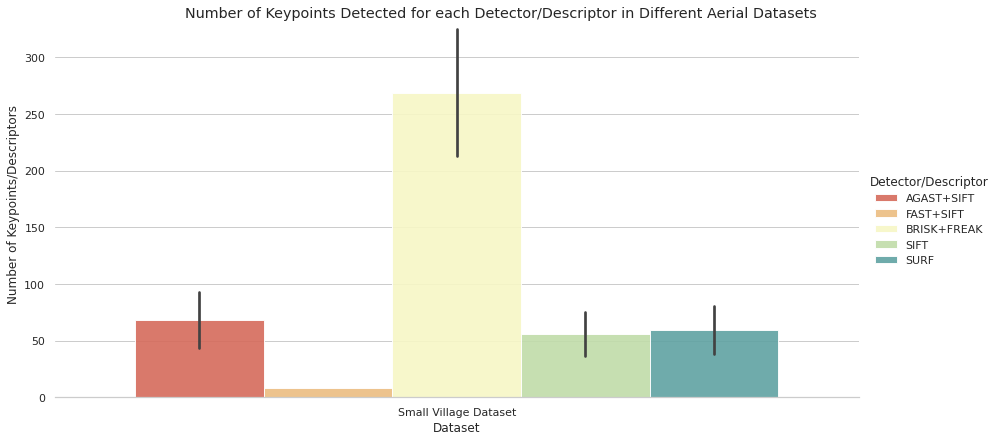

In [57]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [58]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
print(len(num_matches_agast))

119


Total Number of Matches Detected for each Detector+Descriptor

In [59]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

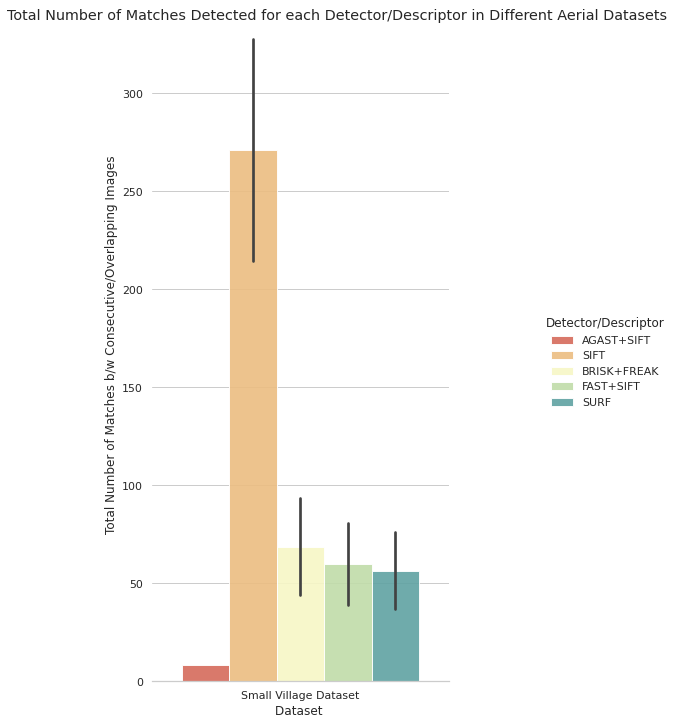

In [60]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [61]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

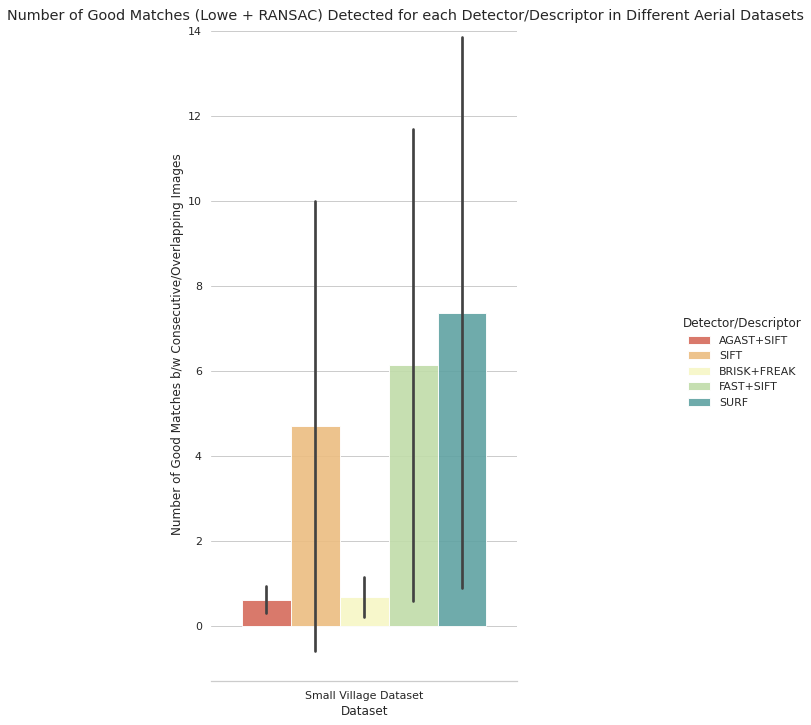

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [63]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

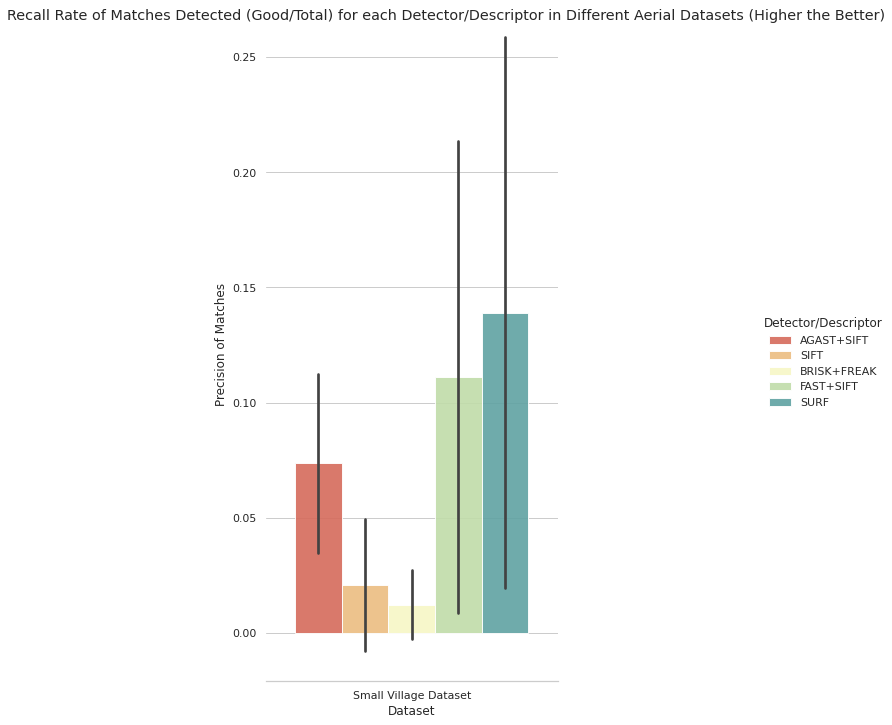

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [65]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

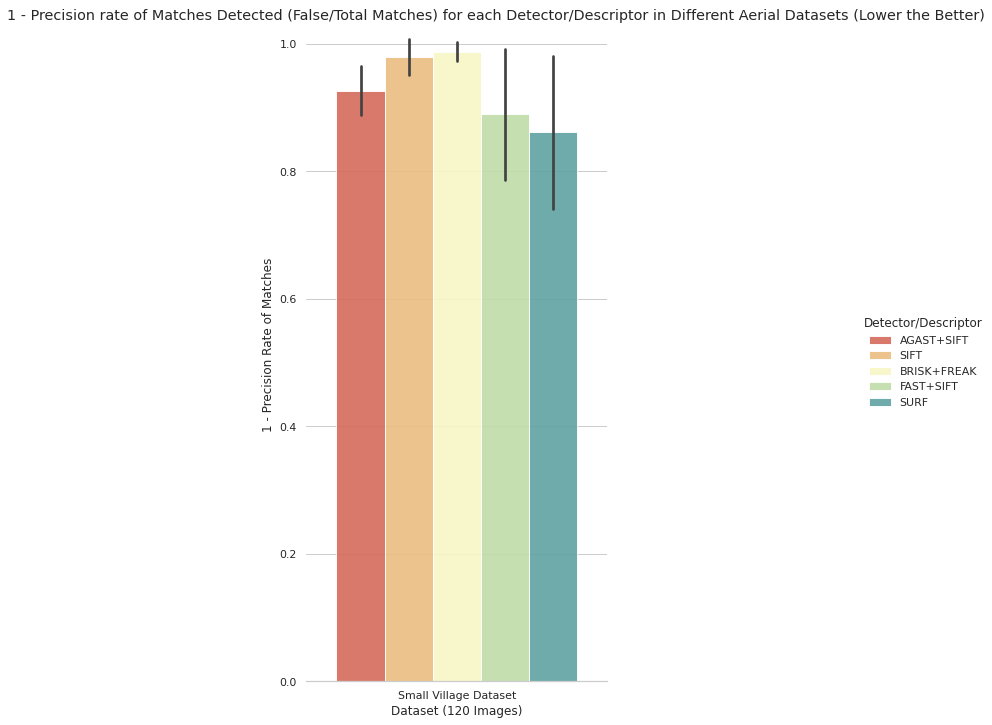

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5,kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [66]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

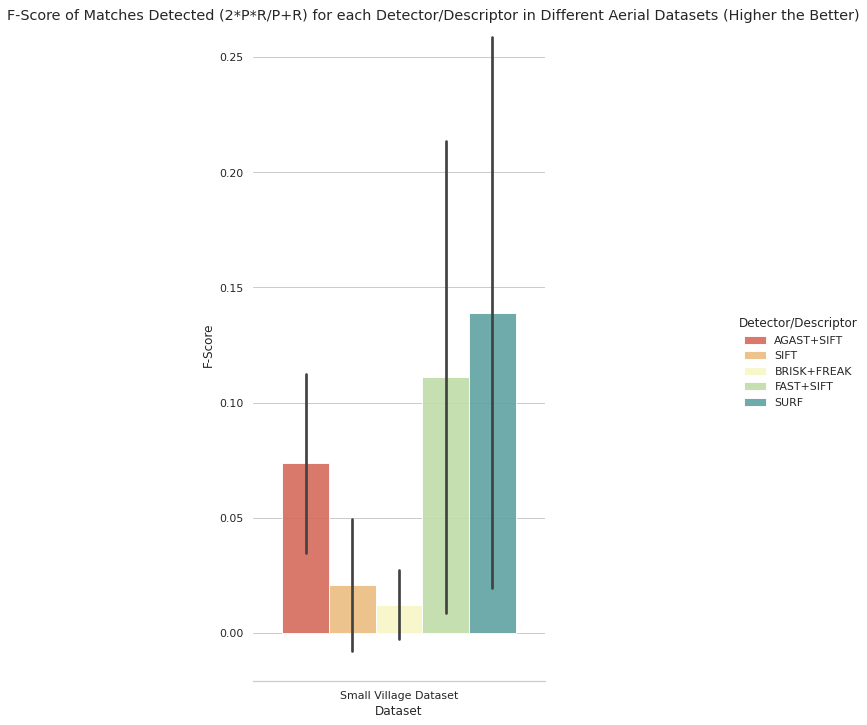

In [67]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [69]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [70]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [71]:
print(df_time_5)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  139.532498          AGAST+SIFT
1  Small Village Dataset   36.723494           FAST+SIFT
2  Small Village Dataset   78.740651         BRISK+FREAK
3  Small Village Dataset   82.426897                SURF
4  Small Village Dataset  236.987143                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

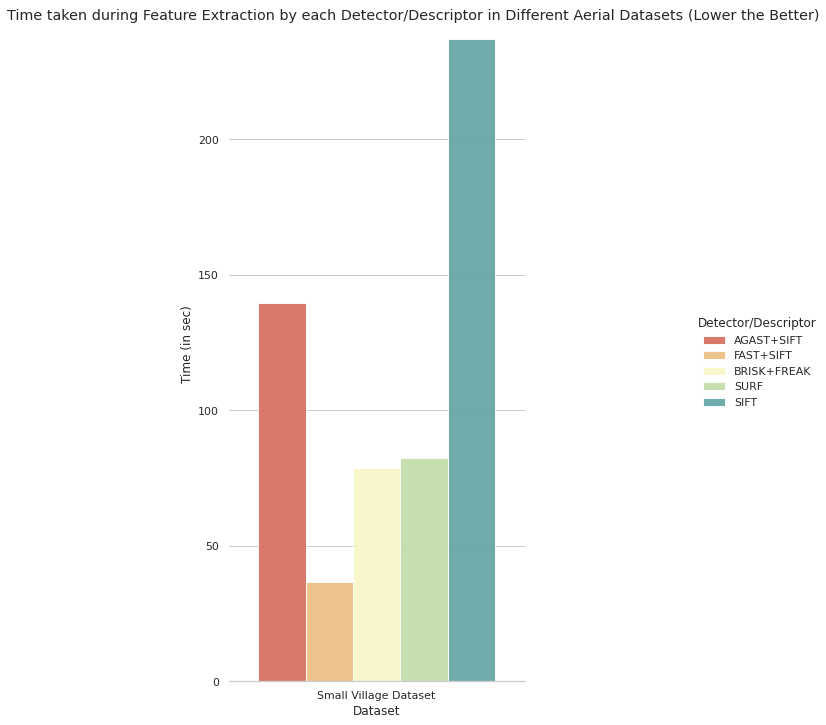

In [72]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [73]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU